In [1]:
import os

# Add Git path to the PATH environment variable
os.environ['PATH'] += os.pathsep + r"C:\Users\boughrio\AppData\Local\Programs\Git\cmd"

# Now try installing the package again
!pip install git+https://github.com/SarraBoughriou/codecarbon.git

  Cloning https://github.com/SarraBoughriou/codecarbon.git to c:\users\boughrio\appdata\local\temp\pip-req-build-e1o7xt73
  Resolved https://github.com/SarraBoughriou/codecarbon.git to commit 45394c0f5a663031a19ec4cb55066501331a396c
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/SarraBoughriou/codecarbon.git 'C:\Users\boughrio\AppData\Local\Temp\pip-req-build-e1o7xt73'


In [2]:
!pip install opencv-python
!pip install tensorflow

[codecarbon WARNING @ 14:20:43] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 14:20:43] [setup] RAM Tracking...
[codecarbon INFO @ 14:20:43] [setup] GPU Tracking...
[codecarbon INFO @ 14:20:43] No GPU found.
[codecarbon INFO @ 14:20:43] [setup] CPU Tracking...
[codecarbon WARNING @ 14:20:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:20:45] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 14:20:45] >>> Tracker's metadata:
[codecarbon INFO @ 14:20:45]   Platform system: Windows-10-10.0.19045-SP0
[codecarbon INFO @ 14:20:45]   Python version: 3.11.7
[codecarbon INFO @ 14:20:45]   CodeCarbon version: 2.4.3rc1
[codecarbon INFO @ 14:20:45]   Available RAM : 15.690 GB
[codecarbon INFO @ 14:20:45]   CPU count: 12
[codecarbon INFO @ 14:20:45]   CPU model: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 14:20:45]   GPU count: None
[codecarbon INFO @ 14:20:45

Training data shape :  (50000, 32, 32, 3) (50000, 1)
Testing data shape :  (10000, 32, 32, 3) (10000, 1)
Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Ground Truth : [3]')

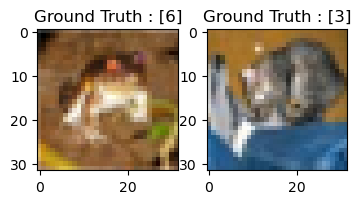

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from codecarbon import EmissionsTracker



trackerTot= EmissionsTracker()
trackerTot.start()

tracker= EmissionsTracker()
tracker.start()

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels)  = tf.keras.datasets.cifar10.load_data()

# Print shapes of training and testing data
print('Training data shape : ', train_images.shape, train_labels.shape)
print('Testing data shape : ', test_images.shape, test_labels.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_labels)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Display the first image in training and testing data
plt.figure(figsize=[4,2])
plt.subplot(121)
plt.imshow(train_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[0]))

plt.subplot(122)
plt.imshow(test_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[0]))



Number of blurry images: 10


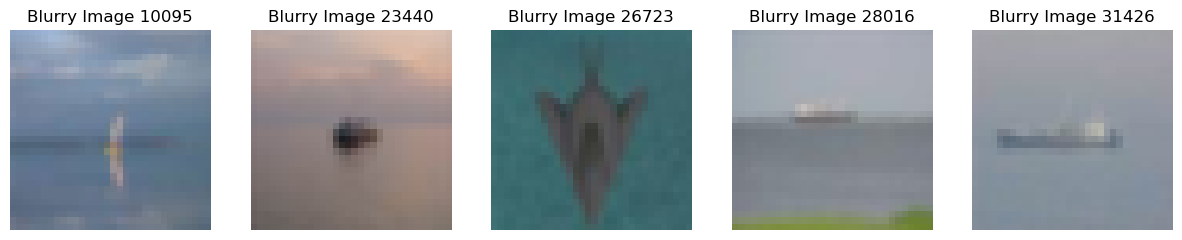

Shape of cleaned dataset: (49990, 32, 32, 3) (49990, 1)
Blurry images deleted.


In [4]:
import cv2
import matplotlib.pyplot as plt

# Function to check if an image is blurry
def is_blurry(image, threshold=100):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute the variance of Laplacian to determine blurriness
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    # Return True if the variance is below the threshold, indicating blur
    return variance < threshold

# Define a function to iterate through images and check for blur
def check_blur(images, threshold=100):
    blurry_images = []
    for i, image in enumerate(images):
        if is_blurry(image, threshold):
            blurry_images.append(i)
    return blurry_images


# Check for blurry images
blurry_indices = check_blur(train_images)

# Print the number of blurry images
print("Number of blurry images:", len(blurry_indices))

# Display the first five blurry images
plt.figure(figsize=(15, 5))
for i, idx in enumerate(blurry_indices[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_images[idx])
    plt.title(f"Blurry Image {idx}")
    plt.axis('off')
plt.show()

# Remove blurry images from the dataset using their indices
train_images = np.delete(train_images, blurry_indices, axis=0)
train_labels = np.delete(train_labels, blurry_indices, axis=0)

# Print the shape of the cleaned dataset
print("Shape of cleaned dataset:", train_images.shape, train_labels.shape)
print("Blurry images deleted.")



In [5]:
# Reshape and preprocess the training and testing data
nRows,nCols,nDims = train_images.shape[1:]
train_data = train_images.reshape(train_images.shape[0], nRows, nCols, nDims)
test_data = test_images.reshape(test_images.shape[0], nRows, nCols, nDims)
input_shape = (nRows, nCols, nDims)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_data /= 255
test_data /= 255

# Convert labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_images)

print('Original label 0 : ', train_labels[0])
print('After conversion to categorical ( one-hot ) : ', train_labels_one_hot[0])

print("Shape of final dataset:", train_data.shape, train_labels.shape)


emissions: float = tracker.stop()
print(f"PreProcessing Emissions:{emissions} Kg")

[codecarbon INFO @ 14:20:58] Energy consumed for RAM : 0.000008 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:20:58] Energy consumed for all CPUs : 0.000042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:20:58] 0.00004963254524143490 kWh of electricity used since the beginning.


Original label 0 :  [6]
After conversion to categorical ( one-hot ) :  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Shape of final dataset: (49990, 32, 32, 3) (49990, 1)
PreProcessing Emissions:1.9603094055022387e-06 Kg


C:\Users\boughrio\AppData\Local\anaconda3\Lib\site-packages\codecarbon\output_methods\file.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])


In [6]:
# Model Definition
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax'),
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the model
model = create_model()

# Learning rate scheduler
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 75:
        lr *= 0.5e-3
    elif epoch > 50:
        lr *= 1e-3
    elif epoch > 25:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tracker= EmissionsTracker()
tracker.start()

# Train the model with augmented data
history = model.fit(datagen.flow(train_images, train_labels_one_hot, batch_size=64),
                    epochs=100,
                    validation_data=(test_images, test_labels_one_hot),
                    callbacks=[lr_scheduler, early_stopping])

emissions: float = tracker.stop()
print(f"Training Emissions:{emissions} Kg")




C:\Users\boughrio\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[codecarbon WARNING @ 14:20:59] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 14:20:59] [setup] RAM Tracking...
[codecarbon INFO @ 14:20:59] [setup] GPU Tracking...
[codecarbon INFO @ 14:20:59] No GPU found.
[codecarbon INFO @ 14:20:59] [setup] CPU Tracking...
[codecarbon WARNING @ 14:20:59] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:21:00] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 14:21:00] >>> Tracker's metadata:
[codecarbon INFO @ 14:21:00]   Platform system: Windows-10-10.0.19045-SP0
[codecar

Epoch 1/100


C:\Users\boughrio\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 88/782 ━━━━━━━━━━━━━━━━━━━━ 1:00 87ms/step - accuracy: 0.1963 - loss: 2.9170

[codecarbon INFO @ 14:21:18] Energy consumed for RAM : 0.000049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:21:18] Energy consumed for all CPUs : 0.000271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:21:18] 0.00032023280023743057 kWh of electricity used since the beginning.


 94/782 ━━━━━━━━━━━━━━━━━━━━ 1:00 89ms/step - accuracy: 0.1987 - loss: 2.8994

[codecarbon INFO @ 14:21:19] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:21:19] Energy consumed for all CPUs : 0.000136 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:21:19] 0.00016023531593152126 kWh of electricity used since the beginning.


242/782 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.2384 - loss: 2.6201

[codecarbon INFO @ 14:21:33] Energy consumed for RAM : 0.000074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:21:33] Energy consumed for all CPUs : 0.000407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:21:33] 0.00048032281530724309 kWh of electricity used since the beginning.


249/782 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - accuracy: 0.2398 - loss: 2.6111

[codecarbon INFO @ 14:21:34] Energy consumed for RAM : 0.000049 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:21:34] Energy consumed for all CPUs : 0.000271 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:21:34] 0.00032042977854274016 kWh of electricity used since the beginning.


411/782 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - accuracy: 0.2659 - loss: 2.4456

[codecarbon INFO @ 14:21:48] Energy consumed for RAM : 0.000098 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:21:48] Energy consumed for all CPUs : 0.000542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:21:48] 0.00064014147017314770 kWh of electricity used since the beginning.


418/782 ━━━━━━━━━━━━━━━━━━━━ 33s 92ms/step - accuracy: 0.2669 - loss: 2.4398

[codecarbon INFO @ 14:21:49] Energy consumed for RAM : 0.000074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:21:49] Energy consumed for all CPUs : 0.000407 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:21:49] 0.00048052641494177663 kWh of electricity used since the beginning.


572/782 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - accuracy: 0.2864 - loss: 2.3294

[codecarbon INFO @ 14:22:03] Energy consumed for RAM : 0.000123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:03] Energy consumed for all CPUs : 0.000678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:03] 0.00080018509193886627 kWh of electricity used since the beginning.


580/782 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.2873 - loss: 2.3244

[codecarbon INFO @ 14:22:04] Energy consumed for RAM : 0.000098 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:04] Energy consumed for all CPUs : 0.000542 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:04] 0.00064039527194242787 kWh of electricity used since the beginning.


732/782 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.3034 - loss: 2.2407

[codecarbon INFO @ 14:22:18] Energy consumed for RAM : 0.000147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:18] Energy consumed for all CPUs : 0.000813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:18] 0.00096016637583970163 kWh of electricity used since the beginning.


740/782 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.3042 - loss: 2.2368

[codecarbon INFO @ 14:22:19] Energy consumed for RAM : 0.000123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:19] Energy consumed for all CPUs : 0.000678 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:19] 0.00080034923168790194 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.3083 - loss: 2.2163 - val_accuracy: 0.5173 - val_loss: 1.3470 - learning_rate: 0.0010
Epoch 2/100
 87/782 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.4757 - loss: 1.4841

[codecarbon INFO @ 14:22:33] Energy consumed for RAM : 0.000172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:33] Energy consumed for all CPUs : 0.000949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:33] 0.00112023557464260588 kWh of electricity used since the beginning.


 95/782 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.4764 - loss: 1.4826

[codecarbon INFO @ 14:22:34] Energy consumed for RAM : 0.000147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:34] Energy consumed for all CPUs : 0.000813 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:34] 0.00096037086080194556 kWh of electricity used since the beginning.


255/782 ━━━━━━━━━━━━━━━━━━━━ 46s 88ms/step - accuracy: 0.4867 - loss: 1.4525

[codecarbon INFO @ 14:22:48] Energy consumed for RAM : 0.000196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:48] Energy consumed for all CPUs : 0.001084 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:48] 0.00128014260051679467 kWh of electricity used since the beginning.


263/782 ━━━━━━━━━━━━━━━━━━━━ 45s 88ms/step - accuracy: 0.4871 - loss: 1.4516

[codecarbon INFO @ 14:22:49] Energy consumed for RAM : 0.000172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:22:49] Energy consumed for all CPUs : 0.000949 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:22:49] 0.00112056083874327106 kWh of electricity used since the beginning.


422/782 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.4931 - loss: 1.4320

[codecarbon INFO @ 14:23:03] Energy consumed for RAM : 0.000221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:03] Energy consumed for all CPUs : 0.001220 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:03] 0.00144009515676679200 kWh of electricity used since the beginning.


430/782 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.4934 - loss: 1.4311

[codecarbon INFO @ 14:23:04] Energy consumed for RAM : 0.000196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:04] Energy consumed for all CPUs : 0.001084 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:04] 0.00128043455597808952 kWh of electricity used since the beginning.


590/782 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.4991 - loss: 1.4134

[codecarbon INFO @ 14:23:18] Energy consumed for RAM : 0.000245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:18] Energy consumed for all CPUs : 0.001355 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:18] 0.00159999287071277592 kWh of electricity used since the beginning.


598/782 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.4994 - loss: 1.4126

[codecarbon INFO @ 14:23:19] Energy consumed for RAM : 0.000221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:19] Energy consumed for all CPUs : 0.001220 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:19] 0.00144034974348579035 kWh of electricity used since the beginning.


760/782 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5048 - loss: 1.3964

[codecarbon INFO @ 14:23:33] Energy consumed for RAM : 0.000270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:33] Energy consumed for all CPUs : 0.001490 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:33] 0.00175999419174001598 kWh of electricity used since the beginning.


769/782 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5051 - loss: 1.3955

[codecarbon INFO @ 14:23:34] Energy consumed for RAM : 0.000245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:34] Energy consumed for all CPUs : 0.001355 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:34] 0.00160025498655862511 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 91ms/step - accuracy: 0.5056 - loss: 1.3942 - val_accuracy: 0.5209 - val_loss: 1.4158 - learning_rate: 0.0010
Epoch 3/100
120/782 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - accuracy: 0.5676 - loss: 1.2416

[codecarbon INFO @ 14:23:48] Energy consumed for RAM : 0.000294 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:48] Energy consumed for all CPUs : 0.001626 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:48] 0.00192024179322868786 kWh of electricity used since the beginning.


128/782 ━━━━━━━━━━━━━━━━━━━━ 58s 90ms/step - accuracy: 0.5683 - loss: 1.2390

[codecarbon INFO @ 14:23:49] Energy consumed for RAM : 0.000270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:23:49] Energy consumed for all CPUs : 0.001491 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:23:49] 0.00176025432431451355 kWh of electricity used since the beginning.


291/782 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.5767 - loss: 1.2094

[codecarbon INFO @ 14:24:03] Energy consumed for RAM : 0.000319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:03] Energy consumed for all CPUs : 0.001762 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:03] 0.00208017374018218014 kWh of electricity used since the beginning.


299/782 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.5769 - loss: 1.2087

[codecarbon INFO @ 14:24:04] Energy consumed for RAM : 0.000294 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:04] Energy consumed for all CPUs : 0.001626 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:04] 0.00192025106262720875 kWh of electricity used since the beginning.


465/782 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.5807 - loss: 1.1949

[codecarbon INFO @ 14:24:18] Energy consumed for RAM : 0.000343 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:18] Energy consumed for all CPUs : 0.001897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:18] 0.00224046947939193644 kWh of electricity used since the beginning.


472/782 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.5809 - loss: 1.1944

[codecarbon INFO @ 14:24:19] Energy consumed for RAM : 0.000319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:19] Energy consumed for all CPUs : 0.001762 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:19] 0.00208030162768042598 kWh of electricity used since the beginning.


639/782 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.5837 - loss: 1.1844

[codecarbon INFO @ 14:24:33] Energy consumed for RAM : 0.000368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:34] Energy consumed for all CPUs : 0.002033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:34] 0.00240067636176274739 kWh of electricity used since the beginning.


646/782 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.5839 - loss: 1.1840

[codecarbon INFO @ 14:24:34] Energy consumed for RAM : 0.000343 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:34] Energy consumed for all CPUs : 0.001897 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:34] 0.00224047131427620007 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.5862 - loss: 1.1768 - val_accuracy: 0.6133 - val_loss: 1.1526 - learning_rate: 0.0010
Epoch 4/100


[codecarbon INFO @ 14:24:48] Energy consumed for RAM : 0.000392 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:49] Energy consumed for all CPUs : 0.002168 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:49] 0.00256061315550264916 kWh of electricity used since the beginning.


  8/782 ━━━━━━━━━━━━━━━━━━━━ 1:03 82ms/step - accuracy: 0.5932 - loss: 1.1548

[codecarbon INFO @ 14:24:49] Energy consumed for RAM : 0.000368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:24:49] Energy consumed for all CPUs : 0.002033 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:24:49] 0.00240029880936678923 kWh of electricity used since the beginning.


181/782 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.6204 - loss: 1.0707

[codecarbon INFO @ 14:25:04] Energy consumed for RAM : 0.000417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:04] Energy consumed for all CPUs : 0.002304 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:04] 0.00272043245634701752 kWh of electricity used since the beginning.


186/782 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - accuracy: 0.6205 - loss: 1.0701

[codecarbon INFO @ 14:25:04] Energy consumed for RAM : 0.000392 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:04] Energy consumed for all CPUs : 0.002168 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:04] 0.00256032068964733234 kWh of electricity used since the beginning.


353/782 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.6242 - loss: 1.0551

[codecarbon INFO @ 14:25:19] Energy consumed for RAM : 0.000441 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:19] Energy consumed for all CPUs : 0.002439 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:19] 0.00288033382691661862 kWh of electricity used since the beginning.


361/782 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - accuracy: 0.6244 - loss: 1.0545

[codecarbon INFO @ 14:25:19] Energy consumed for RAM : 0.000417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:19] Energy consumed for all CPUs : 0.002304 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:19] 0.00272037585028078125 kWh of electricity used since the beginning.


527/782 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.6276 - loss: 1.0447

[codecarbon INFO @ 14:25:34] Energy consumed for RAM : 0.000466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:34] Energy consumed for all CPUs : 0.002575 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:34] 0.00304048306940739137 kWh of electricity used since the beginning.


533/782 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.6277 - loss: 1.0444

[codecarbon INFO @ 14:25:34] Energy consumed for RAM : 0.000441 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:34] Energy consumed for all CPUs : 0.002439 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:34] 0.00288061328827018829 kWh of electricity used since the beginning.


699/782 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.6301 - loss: 1.0379

[codecarbon INFO @ 14:25:49] Energy consumed for RAM : 0.000490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:49] Energy consumed for all CPUs : 0.002710 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:49] 0.00320042168477436629 kWh of electricity used since the beginning.


705/782 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.6301 - loss: 1.0376

[codecarbon INFO @ 14:25:49] Energy consumed for RAM : 0.000466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:25:49] Energy consumed for all CPUs : 0.002575 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:25:49] 0.00304053630672050743 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.6314 - loss: 1.0346 - val_accuracy: 0.6060 - val_loss: 1.2208 - learning_rate: 0.0010
Epoch 5/100
 56/782 ━━━━━━━━━━━━━━━━━━━━ 59s 82ms/step - accuracy: 0.6758 - loss: 0.9172

[codecarbon INFO @ 14:26:04] Energy consumed for RAM : 0.000515 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:04] Energy consumed for all CPUs : 0.002846 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:04] 0.00336045910747076633 kWh of electricity used since the beginning.


 64/782 ━━━━━━━━━━━━━━━━━━━━ 58s 82ms/step - accuracy: 0.6751 - loss: 0.9181

[codecarbon INFO @ 14:26:04] Energy consumed for RAM : 0.000490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:04] Energy consumed for all CPUs : 0.002710 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:04] 0.00320063045400710870 kWh of electricity used since the beginning.


228/782 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - accuracy: 0.6705 - loss: 0.9353

[codecarbon INFO @ 14:26:19] Energy consumed for RAM : 0.000539 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:19] Energy consumed for all CPUs : 0.002981 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:19] 0.00352017678953957074 kWh of electricity used since the beginning.


236/782 ━━━━━━━━━━━━━━━━━━━━ 46s 86ms/step - accuracy: 0.6705 - loss: 0.9357

[codecarbon INFO @ 14:26:19] Energy consumed for RAM : 0.000515 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:19] Energy consumed for all CPUs : 0.002846 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:19] 0.00336062482827406434 kWh of electricity used since the beginning.


399/782 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.6709 - loss: 0.9363

[codecarbon INFO @ 14:26:34] Energy consumed for RAM : 0.000564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:34] Energy consumed for all CPUs : 0.003116 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:34] 0.00368019371767094134 kWh of electricity used since the beginning.


407/782 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.6709 - loss: 0.9363

[codecarbon INFO @ 14:26:34] Energy consumed for RAM : 0.000539 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:34] Energy consumed for all CPUs : 0.002981 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:34] 0.00352075814075181355 kWh of electricity used since the beginning.


570/782 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.6720 - loss: 0.9334

[codecarbon INFO @ 14:26:49] Energy consumed for RAM : 0.000588 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:49] Energy consumed for all CPUs : 0.003252 kWh. Total CPU Power : 32.5 W


571/782 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.6720 - loss: 0.9334

[codecarbon INFO @ 14:26:49] 0.00384011303933399009 kWh of electricity used since the beginning.


578/782 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.6720 - loss: 0.9333

[codecarbon INFO @ 14:26:49] Energy consumed for RAM : 0.000564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:26:49] Energy consumed for all CPUs : 0.003117 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:26:49] 0.00368065441123325166 kWh of electricity used since the beginning.


741/782 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6733 - loss: 0.9303

[codecarbon INFO @ 14:27:04] Energy consumed for RAM : 0.000613 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:04] Energy consumed for all CPUs : 0.003387 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:04] 0.00400011608738925443 kWh of electricity used since the beginning.


749/782 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.6733 - loss: 0.9302

[codecarbon INFO @ 14:27:04] Energy consumed for RAM : 0.000588 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:04] Energy consumed for all CPUs : 0.003252 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:04] 0.00384073301575939751 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.6736 - loss: 0.9296 - val_accuracy: 0.7250 - val_loss: 0.7930 - learning_rate: 0.0010
Epoch 6/100
103/782 ━━━━━━━━━━━━━━━━━━━━ 59s 87ms/step - accuracy: 0.7095 - loss: 0.8444

[codecarbon INFO @ 14:27:19] Energy consumed for RAM : 0.000637 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:19] Energy consumed for all CPUs : 0.003523 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:19] 0.00416010058716149815 kWh of electricity used since the beginning.


111/782 ━━━━━━━━━━━━━━━━━━━━ 58s 87ms/step - accuracy: 0.7093 - loss: 0.8442

[codecarbon INFO @ 14:27:19] Energy consumed for RAM : 0.000613 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:19] Energy consumed for all CPUs : 0.003388 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:19] 0.00400063501897078913 kWh of electricity used since the beginning.


274/782 ━━━━━━━━━━━━━━━━━━━━ 44s 87ms/step - accuracy: 0.7065 - loss: 0.8450

[codecarbon INFO @ 14:27:34] Energy consumed for RAM : 0.000662 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:34] Energy consumed for all CPUs : 0.003658 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:34] 0.00432020914717626096 kWh of electricity used since the beginning.


282/782 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - accuracy: 0.7064 - loss: 0.8451

[codecarbon INFO @ 14:27:34] Energy consumed for RAM : 0.000637 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:34] Energy consumed for all CPUs : 0.003523 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:34] 0.00416069767048489990 kWh of electricity used since the beginning.


447/782 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 0.7044 - loss: 0.8482

[codecarbon INFO @ 14:27:49] Energy consumed for RAM : 0.000686 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:49] Energy consumed for all CPUs : 0.003794 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:49] 0.00448004264852281016 kWh of electricity used since the beginning.


454/782 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - accuracy: 0.7044 - loss: 0.8483

[codecarbon INFO @ 14:27:49] Energy consumed for RAM : 0.000662 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:27:49] Energy consumed for all CPUs : 0.003659 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:27:49] 0.00432066372244425522 kWh of electricity used since the beginning.


621/782 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.7032 - loss: 0.8502

[codecarbon INFO @ 14:28:04] Energy consumed for RAM : 0.000711 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:04] Energy consumed for all CPUs : 0.003929 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:04] 0.00464001948073142906 kWh of electricity used since the beginning.


628/782 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.7032 - loss: 0.8503

[codecarbon INFO @ 14:28:04] Energy consumed for RAM : 0.000686 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:04] Energy consumed for all CPUs : 0.003795 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:04] 0.00448100639077937245 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7025 - loss: 0.8516

[codecarbon INFO @ 14:28:19] Energy consumed for RAM : 0.000735 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:19] Energy consumed for all CPUs : 0.004065 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:19] 0.00479986854589238999 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:28:19] Energy consumed for RAM : 0.000711 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:19] Energy consumed for all CPUs : 0.003930 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:19] 0.00464074978452245351 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.7025 - loss: 0.8516 - val_accuracy: 0.7091 - val_loss: 0.8646 - learning_rate: 0.0010
Epoch 7/100
157/782 ━━━━━━━━━━━━━━━━━━━━ 53s 86ms/step - accuracy: 0.7190 - loss: 0.8138

[codecarbon INFO @ 14:28:34] Energy consumed for RAM : 0.000760 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:34] Energy consumed for all CPUs : 0.004200 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:34] 0.00495988310286351285 kWh of electricity used since the beginning.


165/782 ━━━━━━━━━━━━━━━━━━━━ 52s 86ms/step - accuracy: 0.7187 - loss: 0.8145

[codecarbon INFO @ 14:28:34] Energy consumed for RAM : 0.000735 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:34] Energy consumed for all CPUs : 0.004065 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:34] 0.00480077945489744071 kWh of electricity used since the beginning.


326/782 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.7169 - loss: 0.8185

[codecarbon INFO @ 14:28:49] Energy consumed for RAM : 0.000784 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:49] Energy consumed for all CPUs : 0.004336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:49] 0.00512002263370442239 kWh of electricity used since the beginning.


334/782 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.7169 - loss: 0.8186

[codecarbon INFO @ 14:28:49] Energy consumed for RAM : 0.000760 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:28:49] Energy consumed for all CPUs : 0.004201 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:28:49] 0.00496097906205148279 kWh of electricity used since the beginning.


497/782 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.7160 - loss: 0.8193

[codecarbon INFO @ 14:29:04] Energy consumed for RAM : 0.000809 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:04] Energy consumed for all CPUs : 0.004471 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:04] 0.00527992172596327119 kWh of electricity used since the beginning.


503/782 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.7160 - loss: 0.8193

[codecarbon INFO @ 14:29:04] Energy consumed for RAM : 0.000785 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:04] Energy consumed for all CPUs : 0.004336 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:04] 0.00512097049947695185 kWh of electricity used since the beginning.


670/782 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.7160 - loss: 0.8178

[codecarbon INFO @ 14:29:19] Energy consumed for RAM : 0.000833 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:19] Energy consumed for all CPUs : 0.004607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:19] 0.00543999265905388465 kWh of electricity used since the beginning.


678/782 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.7161 - loss: 0.8177

[codecarbon INFO @ 14:29:19] Energy consumed for RAM : 0.000809 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:19] Energy consumed for all CPUs : 0.004472 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:19] 0.00528099256947722751 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.7164 - loss: 0.8164 - val_accuracy: 0.7148 - val_loss: 0.8328 - learning_rate: 0.0010
Epoch 8/100
 33/782 ━━━━━━━━━━━━━━━━━━━━ 1:02 84ms/step - accuracy: 0.7095 - loss: 0.8149

[codecarbon INFO @ 14:29:34] Energy consumed for RAM : 0.000858 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:34] Energy consumed for all CPUs : 0.004742 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:34] 0.00560003533637618185 kWh of electricity used since the beginning.


 39/782 ━━━━━━━━━━━━━━━━━━━━ 1:04 87ms/step - accuracy: 0.7089 - loss: 0.8179

[codecarbon INFO @ 14:29:34] Energy consumed for RAM : 0.000834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:34] Energy consumed for all CPUs : 0.004607 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:34] 0.00544098257627803877 kWh of electricity used since the beginning.


205/782 ━━━━━━━━━━━━━━━━━━━━ 49s 86ms/step - accuracy: 0.7172 - loss: 0.8142

[codecarbon INFO @ 14:29:49] Energy consumed for RAM : 0.000882 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:49] Energy consumed for all CPUs : 0.004878 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:49] 0.00576012588180326458 kWh of electricity used since the beginning.


213/782 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.7175 - loss: 0.8134

[codecarbon INFO @ 14:29:49] Energy consumed for RAM : 0.000858 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:29:49] Energy consumed for all CPUs : 0.004743 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:29:49] 0.00560130899417001903 kWh of electricity used since the beginning.


374/782 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step - accuracy: 0.7218 - loss: 0.8030

[codecarbon INFO @ 14:30:04] Energy consumed for RAM : 0.000907 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:04] Energy consumed for all CPUs : 0.005013 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:30:04] 0.00592029462306044307 kWh of electricity used since the beginning.


382/782 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step - accuracy: 0.7219 - loss: 0.8026

[codecarbon INFO @ 14:30:04] Energy consumed for RAM : 0.000883 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:04] Energy consumed for all CPUs : 0.004879 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:30:04] 0.00576114355297552803 kWh of electricity used since the beginning.


546/782 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.7248 - loss: 0.7956

[codecarbon INFO @ 14:30:19] Energy consumed for RAM : 0.000931 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:19] Energy consumed for all CPUs : 0.005149 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:30:19] 0.00608005275959976402 kWh of electricity used since the beginning.


554/782 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.7249 - loss: 0.7953

[codecarbon INFO @ 14:30:19] Energy consumed for RAM : 0.000907 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:19] Energy consumed for all CPUs : 0.005014 kWh. Total CPU Power : 32.5 W


555/782 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.7249 - loss: 0.7952

[codecarbon INFO @ 14:30:19] 0.00592131795331545235 kWh of electricity used since the beginning.


718/782 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.7271 - loss: 0.7894

[codecarbon INFO @ 14:30:34] Energy consumed for RAM : 0.000956 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:34] Energy consumed for all CPUs : 0.005284 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:30:34] 0.00624011377215914851 kWh of electricity used since the beginning.


726/782 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.7272 - loss: 0.7892

[codecarbon INFO @ 14:30:34] Energy consumed for RAM : 0.000932 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:34] Energy consumed for all CPUs : 0.005150 kWh. Total CPU Power : 32.5 W


727/782 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.7272 - loss: 0.7892

[codecarbon INFO @ 14:30:34] 0.00608111483538067293 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.7278 - loss: 0.7877 - val_accuracy: 0.7369 - val_loss: 0.7988 - learning_rate: 0.0010
Epoch 9/100
 81/782 ━━━━━━━━━━━━━━━━━━━━ 57s 82ms/step - accuracy: 0.7518 - loss: 0.7414

[codecarbon INFO @ 14:30:49] Energy consumed for RAM : 0.000980 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:49] Energy consumed for all CPUs : 0.005420 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:30:49] 0.00640008150250226220 kWh of electricity used since the beginning.


 89/782 ━━━━━━━━━━━━━━━━━━━━ 57s 83ms/step - accuracy: 0.7514 - loss: 0.7414

[codecarbon INFO @ 14:30:49] Energy consumed for RAM : 0.000956 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:30:50] Energy consumed for all CPUs : 0.005285 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:30:50] 0.00624121902782144057 kWh of electricity used since the beginning.


246/782 ━━━━━━━━━━━━━━━━━━━━ 47s 88ms/step - accuracy: 0.7486 - loss: 0.7409

[codecarbon INFO @ 14:31:04] Energy consumed for RAM : 0.001005 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:04] Energy consumed for all CPUs : 0.005555 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:31:04] 0.00655988747846331793 kWh of electricity used since the beginning.


255/782 ━━━━━━━━━━━━━━━━━━━━ 46s 88ms/step - accuracy: 0.7485 - loss: 0.7410

[codecarbon INFO @ 14:31:05] Energy consumed for RAM : 0.000981 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:05] Energy consumed for all CPUs : 0.005420 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:31:05] 0.00640101902110659735 kWh of electricity used since the beginning.


415/782 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.7468 - loss: 0.7413

[codecarbon INFO @ 14:31:19] Energy consumed for RAM : 0.001029 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:19] Energy consumed for all CPUs : 0.005691 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:31:19] 0.00671990043382536279 kWh of electricity used since the beginning.


423/782 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.7468 - loss: 0.7412

[codecarbon INFO @ 14:31:20] Energy consumed for RAM : 0.001005 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:20] Energy consumed for all CPUs : 0.005556 kWh. Total CPU Power : 32.5 W


424/782 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.7468 - loss: 0.7412

[codecarbon INFO @ 14:31:20] 0.00656115492473969501 kWh of electricity used since the beginning.


584/782 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.7463 - loss: 0.7407

[codecarbon INFO @ 14:31:34] Energy consumed for RAM : 0.001054 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:34] Energy consumed for all CPUs : 0.005826 kWh. Total CPU Power : 32.5 W


585/782 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.7463 - loss: 0.7407

[codecarbon INFO @ 14:31:34] 0.00688001172954225745 kWh of electricity used since the beginning.


593/782 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.7463 - loss: 0.7406

[codecarbon INFO @ 14:31:35] Energy consumed for RAM : 0.001030 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:35] Energy consumed for all CPUs : 0.005692 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:31:35] 0.00672139870184906146 kWh of electricity used since the beginning.


757/782 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.7462 - loss: 0.7401

[codecarbon INFO @ 14:31:49] Energy consumed for RAM : 0.001078 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:49] Energy consumed for all CPUs : 0.005962 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:31:49] 0.00703994266589657702 kWh of electricity used since the beginning.


765/782 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7462 - loss: 0.7401

[codecarbon INFO @ 14:31:50] Energy consumed for RAM : 0.001054 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:31:50] Energy consumed for all CPUs : 0.005827 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:31:50] 0.00688122117221492708 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.7462 - loss: 0.7401 - val_accuracy: 0.7635 - val_loss: 0.7090 - learning_rate: 0.0010
Epoch 10/100
117/782 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - accuracy: 0.7602 - loss: 0.6936

[codecarbon INFO @ 14:32:04] Energy consumed for RAM : 0.001103 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:04] Energy consumed for all CPUs : 0.006097 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:04] 0.00719992868831856401 kWh of electricity used since the beginning.


125/782 ━━━━━━━━━━━━━━━━━━━━ 58s 89ms/step - accuracy: 0.7598 - loss: 0.6945

[codecarbon INFO @ 14:32:05] Energy consumed for RAM : 0.001079 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:05] Energy consumed for all CPUs : 0.005963 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:05] 0.00704124125282986658 kWh of electricity used since the beginning.


291/782 ━━━━━━━━━━━━━━━━━━━━ 42s 87ms/step - accuracy: 0.7546 - loss: 0.7083

[codecarbon INFO @ 14:32:19] Energy consumed for RAM : 0.001127 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:19] Energy consumed for all CPUs : 0.006233 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:19] 0.00735999217196141569 kWh of electricity used since the beginning.


299/782 ━━━━━━━━━━━━━━━━━━━━ 42s 88ms/step - accuracy: 0.7545 - loss: 0.7086

[codecarbon INFO @ 14:32:20] Energy consumed for RAM : 0.001103 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:20] Energy consumed for all CPUs : 0.006098 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:20] 0.00720107890712512293 kWh of electricity used since the beginning.


465/782 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.7540 - loss: 0.7114

[codecarbon INFO @ 14:32:34] Energy consumed for RAM : 0.001152 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:34] Energy consumed for all CPUs : 0.006368 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:34] 0.00751999933018813755 kWh of electricity used since the beginning.


472/782 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.7540 - loss: 0.7115

[codecarbon INFO @ 14:32:35] Energy consumed for RAM : 0.001128 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:35] Energy consumed for all CPUs : 0.006233 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:35] 0.00736108779482203684 kWh of electricity used since the beginning.


638/782 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.7540 - loss: 0.7123

[codecarbon INFO @ 14:32:49] Energy consumed for RAM : 0.001176 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:49] Energy consumed for all CPUs : 0.006504 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:49] 0.00768017542030414741 kWh of electricity used since the beginning.


646/782 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.7540 - loss: 0.7123

[codecarbon INFO @ 14:32:50] Energy consumed for RAM : 0.001152 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:32:50] Energy consumed for all CPUs : 0.006369 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:32:50] 0.00752125534988936761 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.7542 - loss: 0.7123 - val_accuracy: 0.7382 - val_loss: 0.7462 - learning_rate: 0.0010
Epoch 11/100


[codecarbon INFO @ 14:33:04] Energy consumed for RAM : 0.001201 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:04] Energy consumed for all CPUs : 0.006639 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:04] 0.00784000507632522971 kWh of electricity used since the beginning.


  6/782 ━━━━━━━━━━━━━━━━━━━━ 1:04 83ms/step - accuracy: 0.7280 - loss: 0.7673

[codecarbon INFO @ 14:33:05] Energy consumed for RAM : 0.001177 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:05] Energy consumed for all CPUs : 0.006505 kWh. Total CPU Power : 32.5 W


  7/782 ━━━━━━━━━━━━━━━━━━━━ 1:03 83ms/step - accuracy: 0.7283 - loss: 0.7623

[codecarbon INFO @ 14:33:05] 0.00768130154628827565 kWh of electricity used since the beginning.


177/782 ━━━━━━━━━━━━━━━━━━━━ 50s 84ms/step - accuracy: 0.7643 - loss: 0.6878

[codecarbon INFO @ 14:33:19] Energy consumed for RAM : 0.001225 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:19] Energy consumed for all CPUs : 0.006775 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:19] 0.00800012655570750582 kWh of electricity used since the beginning.


185/782 ━━━━━━━━━━━━━━━━━━━━ 50s 84ms/step - accuracy: 0.7645 - loss: 0.6873

[codecarbon INFO @ 14:33:20] Energy consumed for RAM : 0.001201 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:20] Energy consumed for all CPUs : 0.006640 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:20] 0.00784136121719117979 kWh of electricity used since the beginning.


351/782 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.7647 - loss: 0.6860

[codecarbon INFO @ 14:33:34] Energy consumed for RAM : 0.001250 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:34] Energy consumed for all CPUs : 0.006910 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:34] 0.00815994689132704815 kWh of electricity used since the beginning.


358/782 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.7646 - loss: 0.6861

[codecarbon INFO @ 14:33:35] Energy consumed for RAM : 0.001226 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:35] Energy consumed for all CPUs : 0.006776 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:35] 0.00800131850295475282 kWh of electricity used since the beginning.


524/782 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.7632 - loss: 0.6889

[codecarbon INFO @ 14:33:49] Energy consumed for RAM : 0.001274 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:49] Energy consumed for all CPUs : 0.007045 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:49] 0.00831990037259735388 kWh of electricity used since the beginning.


532/782 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.7631 - loss: 0.6890

[codecarbon INFO @ 14:33:50] Energy consumed for RAM : 0.001250 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:33:50] Energy consumed for all CPUs : 0.006911 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:33:50] 0.00816120676443933719 kWh of electricity used since the beginning.


695/782 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.7627 - loss: 0.6898

[codecarbon INFO @ 14:34:04] Energy consumed for RAM : 0.001299 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:04] Energy consumed for all CPUs : 0.007181 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:04] 0.00848004629556646169 kWh of electricity used since the beginning.


704/782 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.7626 - loss: 0.6898

[codecarbon INFO @ 14:34:05] Energy consumed for RAM : 0.001275 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:05] Energy consumed for all CPUs : 0.007047 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:05] 0.00832121257878524860 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.7626 - loss: 0.6899 - val_accuracy: 0.7706 - val_loss: 0.6830 - learning_rate: 0.0010
Epoch 12/100
 57/782 ━━━━━━━━━━━━━━━━━━━━ 58s 80ms/step - accuracy: 0.7798 - loss: 0.6588

[codecarbon INFO @ 14:34:19] Energy consumed for RAM : 0.001324 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:19] Energy consumed for all CPUs : 0.007316 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:19] 0.00864000842921849518 kWh of electricity used since the beginning.


 66/782 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.7788 - loss: 0.6605

[codecarbon INFO @ 14:34:20] Energy consumed for RAM : 0.001299 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:20] Energy consumed for all CPUs : 0.007182 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:20] 0.00848124802200226832 kWh of electricity used since the beginning.


229/782 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - accuracy: 0.7763 - loss: 0.6538

[codecarbon INFO @ 14:34:34] Energy consumed for RAM : 0.001348 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:34] Energy consumed for all CPUs : 0.007452 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:34] 0.00879994424409481606 kWh of electricity used since the beginning.


238/782 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - accuracy: 0.7763 - loss: 0.6534

[codecarbon INFO @ 14:34:35] Energy consumed for RAM : 0.001324 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:35] Energy consumed for all CPUs : 0.007318 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:35] 0.00864139569222250985 kWh of electricity used since the beginning.


401/782 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.7783 - loss: 0.6458

[codecarbon INFO @ 14:34:49] Energy consumed for RAM : 0.001373 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:49] Energy consumed for all CPUs : 0.007587 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:49] 0.00895986413016918240 kWh of electricity used since the beginning.


410/782 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.7784 - loss: 0.6455

[codecarbon INFO @ 14:34:50] Energy consumed for RAM : 0.001348 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:34:50] Energy consumed for all CPUs : 0.007453 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:34:50] 0.00880137183663885596 kWh of electricity used since the beginning.


572/782 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.7798 - loss: 0.6408

[codecarbon INFO @ 14:35:04] Energy consumed for RAM : 0.001397 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:04] Energy consumed for all CPUs : 0.007723 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:04] 0.00911991413702564063 kWh of electricity used since the beginning.


581/782 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.7799 - loss: 0.6405

[codecarbon INFO @ 14:35:05] Energy consumed for RAM : 0.001373 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:05] Energy consumed for all CPUs : 0.007589 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:05] 0.00896125459447429454 kWh of electricity used since the beginning.


743/782 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.7811 - loss: 0.6364

[codecarbon INFO @ 14:35:19] Energy consumed for RAM : 0.001422 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:19] Energy consumed for all CPUs : 0.007858 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:19] 0.00928003680981713021 kWh of electricity used since the beginning.


752/782 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.7812 - loss: 0.6362

[codecarbon INFO @ 14:35:20] Energy consumed for RAM : 0.001397 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:20] Energy consumed for all CPUs : 0.007724 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:20] 0.00912137923801137861 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.7814 - loss: 0.6354 - val_accuracy: 0.8122 - val_loss: 0.5591 - learning_rate: 1.0000e-04
Epoch 13/100
102/782 ━━━━━━━━━━━━━━━━━━━━ 1:01 90ms/step - accuracy: 0.7997 - loss: 0.5690

[codecarbon INFO @ 14:35:34] Energy consumed for RAM : 0.001446 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:34] Energy consumed for all CPUs : 0.007994 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:34] 0.00944006131800892434 kWh of electricity used since the beginning.


111/782 ━━━━━━━━━━━━━━━━━━━━ 59s 89ms/step - accuracy: 0.7992 - loss: 0.5703

[codecarbon INFO @ 14:35:35] Energy consumed for RAM : 0.001422 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:35] Energy consumed for all CPUs : 0.007860 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:35] 0.00928141226036130300 kWh of electricity used since the beginning.


272/782 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.7947 - loss: 0.5821

[codecarbon INFO @ 14:35:49] Energy consumed for RAM : 0.001471 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:49] Energy consumed for all CPUs : 0.008129 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:49] 0.00959996650473286979 kWh of electricity used since the beginning.


280/782 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.7946 - loss: 0.5824

[codecarbon INFO @ 14:35:50] Energy consumed for RAM : 0.001446 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:35:50] Energy consumed for all CPUs : 0.007995 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:35:50] 0.00944125379788758948 kWh of electricity used since the beginning.


438/782 ━━━━━━━━━━━━━━━━━━━━ 30s 89ms/step - accuracy: 0.7943 - loss: 0.5857

[codecarbon INFO @ 14:36:04] Energy consumed for RAM : 0.001495 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:04] Energy consumed for all CPUs : 0.008265 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:36:04] 0.00975998524803634547 kWh of electricity used since the beginning.


446/782 ━━━━━━━━━━━━━━━━━━━━ 30s 89ms/step - accuracy: 0.7943 - loss: 0.5857

[codecarbon INFO @ 14:36:05] Energy consumed for RAM : 0.001471 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:05] Energy consumed for all CPUs : 0.008131 kWh. Total CPU Power : 32.5 W


447/782 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.7943 - loss: 0.5858

[codecarbon INFO @ 14:36:05] 0.00960131275130959513 kWh of electricity used since the beginning.


610/782 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.7947 - loss: 0.5871

[codecarbon INFO @ 14:36:19] Energy consumed for RAM : 0.001520 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:19] Energy consumed for all CPUs : 0.008400 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:36:19] 0.00991999321272039186 kWh of electricity used since the beginning.


618/782 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.7947 - loss: 0.5871

[codecarbon INFO @ 14:36:20] Energy consumed for RAM : 0.001495 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:20] Energy consumed for all CPUs : 0.008266 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:36:20] 0.00976133024517956971 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7953 - loss: 0.5870

[codecarbon INFO @ 14:36:34] Energy consumed for RAM : 0.001544 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:34] Energy consumed for all CPUs : 0.008536 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:36:34] 0.01007997659275306108 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:36:35] Energy consumed for RAM : 0.001520 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:35] Energy consumed for all CPUs : 0.008401 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:36:35] 0.00992135258977568969 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 91ms/step - accuracy: 0.7953 - loss: 0.5870 - val_accuracy: 0.8202 - val_loss: 0.5328 - learning_rate: 1.0000e-04
Epoch 14/100
145/782 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.8015 - loss: 0.5755

[codecarbon INFO @ 14:36:49] Energy consumed for RAM : 0.001569 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:49] Energy consumed for all CPUs : 0.008671 kWh. Total CPU Power : 32.5 W


146/782 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.8015 - loss: 0.5754

[codecarbon INFO @ 14:36:49] 0.01024015401737335060 kWh of electricity used since the beginning.


154/782 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.8015 - loss: 0.5752

[codecarbon INFO @ 14:36:50] Energy consumed for RAM : 0.001544 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:36:50] Energy consumed for all CPUs : 0.008537 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:36:50] 0.01008173264953546137 kWh of electricity used since the beginning.


319/782 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.8022 - loss: 0.5759

[codecarbon INFO @ 14:37:04] Energy consumed for RAM : 0.001593 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:04] Energy consumed for all CPUs : 0.008807 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:04] 0.01040027934702679804 kWh of electricity used since the beginning.


327/782 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.8022 - loss: 0.5759

[codecarbon INFO @ 14:37:05] Energy consumed for RAM : 0.001569 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:05] Energy consumed for all CPUs : 0.008673 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:05] 0.01024158520908645745 kWh of electricity used since the beginning.


492/782 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.8028 - loss: 0.5754

[codecarbon INFO @ 14:37:19] Energy consumed for RAM : 0.001618 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:19] Energy consumed for all CPUs : 0.008942 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:19] 0.01055999738360369027 kWh of electricity used since the beginning.


501/782 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.8028 - loss: 0.5754

[codecarbon INFO @ 14:37:20] Energy consumed for RAM : 0.001593 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:20] Energy consumed for all CPUs : 0.008808 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:20] 0.01040165869710462342 kWh of electricity used since the beginning.


665/782 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.8024 - loss: 0.5764

[codecarbon INFO @ 14:37:34] Energy consumed for RAM : 0.001642 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:34] Energy consumed for all CPUs : 0.009078 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:34] 0.01072017931815710638 kWh of electricity used since the beginning.


673/782 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.8024 - loss: 0.5764

[codecarbon INFO @ 14:37:35] Energy consumed for RAM : 0.001618 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:35] Energy consumed for all CPUs : 0.008944 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:35] 0.01056171943846869951 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.8022 - loss: 0.5770 - val_accuracy: 0.8186 - val_loss: 0.5373 - learning_rate: 1.0000e-04
Epoch 15/100
 26/782 ━━━━━━━━━━━━━━━━━━━━ 1:03 84ms/step - accuracy: 0.8050 - loss: 0.5614

[codecarbon INFO @ 14:37:49] Energy consumed for RAM : 0.001667 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:49] Energy consumed for all CPUs : 0.009213 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:49] 0.01088025739728697844 kWh of electricity used since the beginning.


 34/782 ━━━━━━━━━━━━━━━━━━━━ 1:04 86ms/step - accuracy: 0.8042 - loss: 0.5651

[codecarbon INFO @ 14:37:50] Energy consumed for RAM : 0.001642 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:37:50] Energy consumed for all CPUs : 0.009079 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:37:50] 0.01072155088145316897 kWh of electricity used since the beginning.


198/782 ━━━━━━━━━━━━━━━━━━━━ 50s 87ms/step - accuracy: 0.8017 - loss: 0.5716

[codecarbon INFO @ 14:38:04] Energy consumed for RAM : 0.001691 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:04] Energy consumed for all CPUs : 0.009349 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:38:04] 0.01104016893166092153 kWh of electricity used since the beginning.


207/782 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.8017 - loss: 0.5715

[codecarbon INFO @ 14:38:05] Energy consumed for RAM : 0.001667 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:05] Energy consumed for all CPUs : 0.009215 kWh. Total CPU Power : 32.5 W


208/782 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.8017 - loss: 0.5715

[codecarbon INFO @ 14:38:05] 0.01088204263161991758 kWh of electricity used since the beginning.


369/782 ━━━━━━━━━━━━━━━━━━━━ 36s 87ms/step - accuracy: 0.8020 - loss: 0.5722

[codecarbon INFO @ 14:38:19] Energy consumed for RAM : 0.001716 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:19] Energy consumed for all CPUs : 0.009484 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:38:19] 0.01120003478497614939 kWh of electricity used since the beginning.


379/782 ━━━━━━━━━━━━━━━━━━━━ 35s 87ms/step - accuracy: 0.8020 - loss: 0.5723

[codecarbon INFO @ 14:38:20] Energy consumed for RAM : 0.001691 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:20] Energy consumed for all CPUs : 0.009350 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:38:20] 0.01104170834176470238 kWh of electricity used since the beginning.


540/782 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.8018 - loss: 0.5730

[codecarbon INFO @ 14:38:34] Energy consumed for RAM : 0.001740 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:34] Energy consumed for all CPUs : 0.009620 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:38:34] 0.01136005842518102854 kWh of electricity used since the beginning.


549/782 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.8018 - loss: 0.5730

[codecarbon INFO @ 14:38:35] Energy consumed for RAM : 0.001716 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:35] Energy consumed for all CPUs : 0.009486 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:38:35] 0.01120169250923689318 kWh of electricity used since the beginning.


711/782 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.8018 - loss: 0.5731

[codecarbon INFO @ 14:38:49] Energy consumed for RAM : 0.001765 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:49] Energy consumed for all CPUs : 0.009755 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:38:49] 0.01151993958038293950 kWh of electricity used since the beginning.


720/782 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8018 - loss: 0.5731

[codecarbon INFO @ 14:38:50] Energy consumed for RAM : 0.001740 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:38:50] Energy consumed for all CPUs : 0.009621 kWh. Total CPU Power : 32.5 W


721/782 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8018 - loss: 0.5731

[codecarbon INFO @ 14:38:50] 0.01136179132781177555 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.8018 - loss: 0.5730 - val_accuracy: 0.8193 - val_loss: 0.5467 - learning_rate: 1.0000e-04
Epoch 16/100
 73/782 ━━━━━━━━━━━━━━━━━━━━ 58s 82ms/step - accuracy: 0.8075 - loss: 0.5780

[codecarbon INFO @ 14:39:04] Energy consumed for RAM : 0.001789 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:04] Energy consumed for all CPUs : 0.009891 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:04] 0.01167983585178133422 kWh of electricity used since the beginning.


 82/782 ━━━━━━━━━━━━━━━━━━━━ 57s 82ms/step - accuracy: 0.8078 - loss: 0.5762

[codecarbon INFO @ 14:39:05] Energy consumed for RAM : 0.001765 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:05] Energy consumed for all CPUs : 0.009757 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:05] 0.01152172212406280850 kWh of electricity used since the beginning.


243/782 ━━━━━━━━━━━━━━━━━━━━ 46s 86ms/step - accuracy: 0.8081 - loss: 0.5690

[codecarbon INFO @ 14:39:19] Energy consumed for RAM : 0.001814 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:19] Energy consumed for all CPUs : 0.010026 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:19] 0.01183979839177603556 kWh of electricity used since the beginning.


252/782 ━━━━━━━━━━━━━━━━━━━━ 45s 86ms/step - accuracy: 0.8081 - loss: 0.5687

[codecarbon INFO @ 14:39:20] Energy consumed for RAM : 0.001789 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:20] Energy consumed for all CPUs : 0.009892 kWh. Total CPU Power : 32.5 W


253/782 ━━━━━━━━━━━━━━━━━━━━ 45s 86ms/step - accuracy: 0.8081 - loss: 0.5687

[codecarbon INFO @ 14:39:20] 0.01168164964609040221 kWh of electricity used since the beginning.


415/782 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.8088 - loss: 0.5639

[codecarbon INFO @ 14:39:34] Energy consumed for RAM : 0.001838 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:34] Energy consumed for all CPUs : 0.010161 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:34] 0.01199980740971598112 kWh of electricity used since the beginning.


424/782 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.8088 - loss: 0.5638

[codecarbon INFO @ 14:39:35] Energy consumed for RAM : 0.001814 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:35] Energy consumed for all CPUs : 0.010028 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:35] 0.01184194887089004382 kWh of electricity used since the beginning.


578/782 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.8087 - loss: 0.5627

[codecarbon INFO @ 14:39:49] Energy consumed for RAM : 0.001863 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:49] Energy consumed for all CPUs : 0.010297 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:49] 0.01215989955300949936 kWh of electricity used since the beginning.


588/782 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.8087 - loss: 0.5627

[codecarbon INFO @ 14:39:50] Energy consumed for RAM : 0.001838 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:39:50] Energy consumed for all CPUs : 0.010163 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:39:50] 0.01200162065542897082 kWh of electricity used since the beginning.


747/782 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.8083 - loss: 0.5622

[codecarbon INFO @ 14:40:04] Energy consumed for RAM : 0.001887 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:04] Energy consumed for all CPUs : 0.010433 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:04] 0.01232014535798613836 kWh of electricity used since the beginning.


756/782 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.8083 - loss: 0.5622

[codecarbon INFO @ 14:40:05] Energy consumed for RAM : 0.001863 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:05] Energy consumed for all CPUs : 0.010299 kWh. Total CPU Power : 32.5 W


757/782 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.8083 - loss: 0.5622

[codecarbon INFO @ 14:40:05] 0.01216174099674999579 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.8083 - loss: 0.5622 - val_accuracy: 0.8232 - val_loss: 0.5259 - learning_rate: 1.0000e-04
Epoch 17/100
107/782 ━━━━━━━━━━━━━━━━━━━━ 1:00 90ms/step - accuracy: 0.8174 - loss: 0.5300

[codecarbon INFO @ 14:40:19] Energy consumed for RAM : 0.001912 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:19] Energy consumed for all CPUs : 0.010568 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:19] 0.01247994429974438012 kWh of electricity used since the beginning.


116/782 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - accuracy: 0.8169 - loss: 0.5314

[codecarbon INFO @ 14:40:20] Energy consumed for RAM : 0.001888 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:20] Energy consumed for all CPUs : 0.010434 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:20] 0.01232193915913686912 kWh of electricity used since the beginning.


282/782 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - accuracy: 0.8133 - loss: 0.5446

[codecarbon INFO @ 14:40:34] Energy consumed for RAM : 0.001936 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:34] Energy consumed for all CPUs : 0.010704 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:34] 0.01263991160979873081 kWh of electricity used since the beginning.


290/782 ━━━━━━━━━━━━━━━━━━━━ 43s 88ms/step - accuracy: 0.8133 - loss: 0.5448

[codecarbon INFO @ 14:40:35] Energy consumed for RAM : 0.001912 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:35] Energy consumed for all CPUs : 0.010570 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:35] 0.01248192734976145621 kWh of electricity used since the beginning.


454/782 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - accuracy: 0.8125 - loss: 0.5484

[codecarbon INFO @ 14:40:49] Energy consumed for RAM : 0.001961 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:49] Energy consumed for all CPUs : 0.010839 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:49] 0.01280007115966009384 kWh of electricity used since the beginning.


463/782 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.8125 - loss: 0.5485

[codecarbon INFO @ 14:40:50] Energy consumed for RAM : 0.001937 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:40:50] Energy consumed for all CPUs : 0.010705 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:40:50] 0.01264199672399484581 kWh of electricity used since the beginning.


624/782 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.8121 - loss: 0.5493

[codecarbon INFO @ 14:41:04] Energy consumed for RAM : 0.001985 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:04] Energy consumed for all CPUs : 0.010975 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:04] 0.01296007461241623256 kWh of electricity used since the beginning.


633/782 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.8121 - loss: 0.5493

[codecarbon INFO @ 14:41:05] Energy consumed for RAM : 0.001961 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:05] Energy consumed for all CPUs : 0.010841 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:05] 0.01280200885860597292 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8118 - loss: 0.5496

[codecarbon INFO @ 14:41:19] Energy consumed for RAM : 0.002010 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:19] Energy consumed for all CPUs : 0.011110 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:19] 0.01311999606104870437 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:41:20] Energy consumed for RAM : 0.001986 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:20] Energy consumed for all CPUs : 0.010976 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:20] 0.01296187719447912043 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.8118 - loss: 0.5496 - val_accuracy: 0.8299 - val_loss: 0.5107 - learning_rate: 1.0000e-04
Epoch 18/100
162/782 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.8059 - loss: 0.5520

[codecarbon INFO @ 14:41:34] Energy consumed for RAM : 0.002034 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:34] Energy consumed for all CPUs : 0.011246 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:34] 0.01327995386800327922 kWh of electricity used since the beginning.


171/782 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.8060 - loss: 0.5518

[codecarbon INFO @ 14:41:35] Energy consumed for RAM : 0.002010 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:35] Energy consumed for all CPUs : 0.011112 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:35] 0.01312216184310332698 kWh of electricity used since the beginning.


331/782 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.8082 - loss: 0.5507

[codecarbon INFO @ 14:41:49] Energy consumed for RAM : 0.002059 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:49] Energy consumed for all CPUs : 0.011381 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:49] 0.01344006030459580538 kWh of electricity used since the beginning.


339/782 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.8082 - loss: 0.5507

[codecarbon INFO @ 14:41:50] Energy consumed for RAM : 0.002035 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:41:50] Energy consumed for all CPUs : 0.011247 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:41:50] 0.01328206292826139903 kWh of electricity used since the beginning.


502/782 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.8090 - loss: 0.5509

[codecarbon INFO @ 14:42:04] Energy consumed for RAM : 0.002083 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:04] Energy consumed for all CPUs : 0.011517 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:04] 0.01360008721297441270 kWh of electricity used since the beginning.


512/782 ━━━━━━━━━━━━━━━━━━━━ 23s 87ms/step - accuracy: 0.8090 - loss: 0.5509

[codecarbon INFO @ 14:42:05] Energy consumed for RAM : 0.002059 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:05] Energy consumed for all CPUs : 0.011383 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:05] 0.01344198424612974389 kWh of electricity used since the beginning.


674/782 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.8092 - loss: 0.5510

[codecarbon INFO @ 14:42:19] Energy consumed for RAM : 0.002108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:19] Energy consumed for all CPUs : 0.011652 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:19] 0.01375993186580352565 kWh of electricity used since the beginning.


684/782 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.8092 - loss: 0.5510

[codecarbon INFO @ 14:42:20] Energy consumed for RAM : 0.002084 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:20] Energy consumed for all CPUs : 0.011518 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:20] 0.01360205610407696358 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.8094 - loss: 0.5509 - val_accuracy: 0.8276 - val_loss: 0.5193 - learning_rate: 1.0000e-04
Epoch 19/100
 30/782 ━━━━━━━━━━━━━━━━━━━━ 1:07 90ms/step - accuracy: 0.7850 - loss: 0.6100

[codecarbon INFO @ 14:42:34] Energy consumed for RAM : 0.002132 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:34] Energy consumed for all CPUs : 0.011787 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:34] 0.01391996502147924315 kWh of electricity used since the beginning.


 40/782 ━━━━━━━━━━━━━━━━━━━━ 1:07 91ms/step - accuracy: 0.7902 - loss: 0.5960

[codecarbon INFO @ 14:42:35] Energy consumed for RAM : 0.002108 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:35] Energy consumed for all CPUs : 0.011654 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:35] 0.01376197118189267932 kWh of electricity used since the beginning.


200/782 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.8020 - loss: 0.5668

[codecarbon INFO @ 14:42:49] Energy consumed for RAM : 0.002157 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:49] Energy consumed for all CPUs : 0.011923 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:42:49] 0.01408006615093326114 kWh of electricity used since the beginning.


210/782 ━━━━━━━━━━━━━━━━━━━━ 50s 88ms/step - accuracy: 0.8023 - loss: 0.5660

[codecarbon INFO @ 14:42:50] Energy consumed for RAM : 0.002133 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:42:50] Energy consumed for all CPUs : 0.011789 kWh. Total CPU Power : 32.5 W


211/782 ━━━━━━━━━━━━━━━━━━━━ 50s 88ms/step - accuracy: 0.8023 - loss: 0.5660

[codecarbon INFO @ 14:42:50] 0.01392199540100037651 kWh of electricity used since the beginning.


372/782 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step - accuracy: 0.8059 - loss: 0.5572

[codecarbon INFO @ 14:43:04] Energy consumed for RAM : 0.002182 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:43:04] Energy consumed for all CPUs : 0.012059 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:43:04] 0.01424022336247839950 kWh of electricity used since the beginning.


382/782 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step - accuracy: 0.8060 - loss: 0.5569

[codecarbon INFO @ 14:43:05] Energy consumed for RAM : 0.002157 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:43:05] Energy consumed for all CPUs : 0.011925 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:43:05] 0.01408210311931445795 kWh of electricity used since the beginning.


544/782 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.8076 - loss: 0.5524

[codecarbon INFO @ 14:43:19] Energy consumed for RAM : 0.002206 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:43:19] Energy consumed for all CPUs : 0.012194 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:43:19] 0.01440016980361383085 kWh of electricity used since the beginning.


554/782 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.8077 - loss: 0.5522

[codecarbon INFO @ 14:43:20] Energy consumed for RAM : 0.002182 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:43:20] Energy consumed for all CPUs : 0.012060 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:43:20] 0.01424195562984381658 kWh of electricity used since the beginning.


715/782 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8086 - loss: 0.5495

[codecarbon INFO @ 14:43:34] Energy consumed for RAM : 0.002231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:43:34] Energy consumed for all CPUs : 0.012330 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:43:34] 0.01456021610806470211 kWh of electricity used since the beginning.


725/782 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8087 - loss: 0.5493

[codecarbon INFO @ 14:43:35] Energy consumed for RAM : 0.002206 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:43:35] Energy consumed for all CPUs : 0.012196 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:43:35] 0.01440206415923736723 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 91ms/step - accuracy: 0.8088 - loss: 0.5487 - val_accuracy: 0.8310 - val_loss: 0.5148 - learning_rate: 1.0000e-04
Epoch 20/100
 71/782 ━━━━━━━━━━━━━━━━━━━━ 1:02 88ms/step - accuracy: 0.8168 - loss: 0.5337

[codecarbon INFO @ 14:43:49] Energy consumed for RAM : 0.002255 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:43:49] Energy consumed for all CPUs : 0.012465 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:43:49] 0.01472011966456261006 kWh of electricity used since the beginning.


 81/782 ━━━━━━━━━━━━━━━━━━━━ 1:01 88ms/step - accuracy: 0.8160 - loss: 0.5344

[codecarbon INFO @ 14:43:50] Energy consumed for RAM : 0.002231 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:43:50] Energy consumed for all CPUs : 0.012332 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:43:50] 0.01456226136461293702 kWh of electricity used since the beginning.


241/782 ━━━━━━━━━━━━━━━━━━━━ 47s 88ms/step - accuracy: 0.8148 - loss: 0.5283

[codecarbon INFO @ 14:44:04] Energy consumed for RAM : 0.002280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:04] Energy consumed for all CPUs : 0.012601 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:44:04] 0.01488024747304402332 kWh of electricity used since the beginning.


251/782 ━━━━━━━━━━━━━━━━━━━━ 46s 88ms/step - accuracy: 0.8149 - loss: 0.5281

[codecarbon INFO @ 14:44:05] Energy consumed for RAM : 0.002255 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:05] Energy consumed for all CPUs : 0.012467 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:44:05] 0.01472210898810731930 kWh of electricity used since the beginning.


414/782 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.8150 - loss: 0.5282

[codecarbon INFO @ 14:44:19] Energy consumed for RAM : 0.002304 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:19] Energy consumed for all CPUs : 0.012736 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:44:19] 0.01504026774630018957 kWh of electricity used since the beginning.


423/782 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.8150 - loss: 0.5282

[codecarbon INFO @ 14:44:20] Energy consumed for RAM : 0.002280 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:20] Energy consumed for all CPUs : 0.012602 kWh. Total CPU Power : 32.5 W


424/782 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.8150 - loss: 0.5282

[codecarbon INFO @ 14:44:20] 0.01488222567996383416 kWh of electricity used since the beginning.


587/782 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.8147 - loss: 0.5291

[codecarbon INFO @ 14:44:34] Energy consumed for RAM : 0.002329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:34] Energy consumed for all CPUs : 0.012872 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:44:34] 0.01520026074881347146 kWh of electricity used since the beginning.


596/782 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.8147 - loss: 0.5291

[codecarbon INFO @ 14:44:35] Energy consumed for RAM : 0.002304 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:35] Energy consumed for all CPUs : 0.012738 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:44:35] 0.01504230341380159361 kWh of electricity used since the beginning.


760/782 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8145 - loss: 0.5299

[codecarbon INFO @ 14:44:49] Energy consumed for RAM : 0.002353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:49] Energy consumed for all CPUs : 0.013007 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:44:49] 0.01536023202896506963 kWh of electricity used since the beginning.


769/782 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8145 - loss: 0.5300

[codecarbon INFO @ 14:44:50] Energy consumed for RAM : 0.002329 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:44:50] Energy consumed for all CPUs : 0.012873 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:44:50] 0.01520230537699784890 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.8144 - loss: 0.5301 - val_accuracy: 0.8332 - val_loss: 0.5032 - learning_rate: 1.0000e-04
Epoch 21/100
119/782 ━━━━━━━━━━━━━━━━━━━━ 57s 86ms/step - accuracy: 0.8125 - loss: 0.5280

[codecarbon INFO @ 14:45:04] Energy consumed for RAM : 0.002378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:05] Energy consumed for all CPUs : 0.013143 kWh. Total CPU Power : 32.5 W


120/782 ━━━━━━━━━━━━━━━━━━━━ 57s 87ms/step - accuracy: 0.8125 - loss: 0.5280

[codecarbon INFO @ 14:45:05] 0.01552027788182080634 kWh of electricity used since the beginning.


129/782 ━━━━━━━━━━━━━━━━━━━━ 56s 87ms/step - accuracy: 0.8124 - loss: 0.5285

[codecarbon INFO @ 14:45:05] Energy consumed for RAM : 0.002353 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:05] Energy consumed for all CPUs : 0.013009 kWh. Total CPU Power : 32.5 W


130/782 ━━━━━━━━━━━━━━━━━━━━ 56s 87ms/step - accuracy: 0.8124 - loss: 0.5285

[codecarbon INFO @ 14:45:05] 0.01536246867169158842 kWh of electricity used since the beginning.


295/782 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.8131 - loss: 0.5330

[codecarbon INFO @ 14:45:20] Energy consumed for RAM : 0.002402 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:20] Energy consumed for all CPUs : 0.013278 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:45:20] 0.01568025122908710614 kWh of electricity used since the beginning.


303/782 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - accuracy: 0.8131 - loss: 0.5331

[codecarbon INFO @ 14:45:20] Energy consumed for RAM : 0.002378 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:20] Energy consumed for all CPUs : 0.013145 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:45:20] 0.01552253193149822838 kWh of electricity used since the beginning.


467/782 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8134 - loss: 0.5352

[codecarbon INFO @ 14:45:35] Energy consumed for RAM : 0.002427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:35] Energy consumed for all CPUs : 0.013414 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:45:35] 0.01584043245742499523 kWh of electricity used since the beginning.


477/782 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.8135 - loss: 0.5353

[codecarbon INFO @ 14:45:35] Energy consumed for RAM : 0.002402 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:35] Energy consumed for all CPUs : 0.013280 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:45:35] 0.01568264035720736901 kWh of electricity used since the beginning.


638/782 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.8138 - loss: 0.5359

[codecarbon INFO @ 14:45:50] Energy consumed for RAM : 0.002451 kWh. RAM Power : 5.883667945861816 W


639/782 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.8138 - loss: 0.5359

[codecarbon INFO @ 14:45:50] Energy consumed for all CPUs : 0.013549 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:45:50] 0.01600011769610248935 kWh of electricity used since the beginning.


647/782 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.8138 - loss: 0.5359

[codecarbon INFO @ 14:45:50] Energy consumed for RAM : 0.002427 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:45:50] Energy consumed for all CPUs : 0.013416 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:45:50] 0.01584274826354852006 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8142 - loss: 0.5354

[codecarbon INFO @ 14:46:05] Energy consumed for RAM : 0.002476 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:05] Energy consumed for all CPUs : 0.013684 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:05] 0.01616008309781637869 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.8142 - loss: 0.5354 - val_accuracy: 0.8340 - val_loss: 0.5004 - learning_rate: 1.0000e-04
Epoch 22/100
  6/782 ━━━━━━━━━━━━━━━━━━━━ 1:20 103ms/step - accuracy: 0.8056 - loss: 0.5869

[codecarbon INFO @ 14:46:05] Energy consumed for RAM : 0.002451 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:05] Energy consumed for all CPUs : 0.013551 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:05] 0.01600248517051233027 kWh of electricity used since the beginning.


167/782 ━━━━━━━━━━━━━━━━━━━━ 54s 88ms/step - accuracy: 0.8210 - loss: 0.5126

[codecarbon INFO @ 14:46:20] Energy consumed for RAM : 0.002500 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:20] Energy consumed for all CPUs : 0.013820 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:20] 0.01632010481079662623 kWh of electricity used since the beginning.


178/782 ━━━━━━━━━━━━━━━━━━━━ 52s 88ms/step - accuracy: 0.8210 - loss: 0.5127

[codecarbon INFO @ 14:46:20] Energy consumed for RAM : 0.002476 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:20] Energy consumed for all CPUs : 0.013687 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:20] 0.01616245953508919919 kWh of electricity used since the beginning.


338/782 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.8202 - loss: 0.5160

[codecarbon INFO @ 14:46:35] Energy consumed for RAM : 0.002525 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:35] Energy consumed for all CPUs : 0.013955 kWh. Total CPU Power : 32.5 W


339/782 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - accuracy: 0.8202 - loss: 0.5161

[codecarbon INFO @ 14:46:35] 0.01648020158276826408 kWh of electricity used since the beginning.


349/782 ━━━━━━━━━━━━━━━━━━━━ 37s 88ms/step - accuracy: 0.8201 - loss: 0.5163

[codecarbon INFO @ 14:46:35] Energy consumed for RAM : 0.002500 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:35] Energy consumed for all CPUs : 0.013822 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:35] 0.01632251129627606059 kWh of electricity used since the beginning.


509/782 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.8192 - loss: 0.5194

[codecarbon INFO @ 14:46:50] Energy consumed for RAM : 0.002549 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:50] Energy consumed for all CPUs : 0.014091 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:50] 0.01664023391916310407 kWh of electricity used since the beginning.


520/782 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.8192 - loss: 0.5196

[codecarbon INFO @ 14:46:50] Energy consumed for RAM : 0.002525 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:46:50] Energy consumed for all CPUs : 0.013957 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:46:50] 0.01648232666439602631 kWh of electricity used since the beginning.


680/782 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8185 - loss: 0.5220

[codecarbon INFO @ 14:47:05] Energy consumed for RAM : 0.002574 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:05] Energy consumed for all CPUs : 0.014226 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:05] 0.01679997628511910313 kWh of electricity used since the beginning.


691/782 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.8185 - loss: 0.5221

[codecarbon INFO @ 14:47:05] Energy consumed for RAM : 0.002549 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:05] Energy consumed for all CPUs : 0.014093 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:05] 0.01664230921168620772 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.8183 - loss: 0.5230 - val_accuracy: 0.8317 - val_loss: 0.5052 - learning_rate: 1.0000e-04
Epoch 23/100
 40/782 ━━━━━━━━━━━━━━━━━━━━ 1:01 83ms/step - accuracy: 0.8066 - loss: 0.5587

[codecarbon INFO @ 14:47:20] Energy consumed for RAM : 0.002598 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:20] Energy consumed for all CPUs : 0.014362 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:20] 0.01696012317083005899 kWh of electricity used since the beginning.


 51/782 ━━━━━━━━━━━━━━━━━━━━ 1:00 83ms/step - accuracy: 0.8067 - loss: 0.5558

[codecarbon INFO @ 14:47:20] Energy consumed for RAM : 0.002574 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:20] Energy consumed for all CPUs : 0.014228 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:20] 0.01680220543201881370 kWh of electricity used since the beginning.


210/782 ━━━━━━━━━━━━━━━━━━━━ 50s 87ms/step - accuracy: 0.8096 - loss: 0.5456

[codecarbon INFO @ 14:47:35] Energy consumed for RAM : 0.002623 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:35] Energy consumed for all CPUs : 0.014497 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:35] 0.01711998689416313960 kWh of electricity used since the beginning.


220/782 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.8097 - loss: 0.5452

[codecarbon INFO @ 14:47:35] Energy consumed for RAM : 0.002598 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:36] Energy consumed for all CPUs : 0.014364 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:36] 0.01696243903452085769 kWh of electricity used since the beginning.


378/782 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step - accuracy: 0.8119 - loss: 0.5394

[codecarbon INFO @ 14:47:50] Energy consumed for RAM : 0.002647 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:50] Energy consumed for all CPUs : 0.014633 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:50] 0.01727993353619858286 kWh of electricity used since the beginning.


389/782 ━━━━━━━━━━━━━━━━━━━━ 34s 88ms/step - accuracy: 0.8121 - loss: 0.5390

[codecarbon INFO @ 14:47:50] Energy consumed for RAM : 0.002623 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:47:51] Energy consumed for all CPUs : 0.014499 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:47:51] 0.01712231691552625057 kWh of electricity used since the beginning.


549/782 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.8135 - loss: 0.5351

[codecarbon INFO @ 14:48:05] Energy consumed for RAM : 0.002672 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:05] Energy consumed for all CPUs : 0.014768 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:05] 0.01744000211458946945 kWh of electricity used since the beginning.


560/782 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.8136 - loss: 0.5348

[codecarbon INFO @ 14:48:06] Energy consumed for RAM : 0.002647 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:06] Energy consumed for all CPUs : 0.014635 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:06] 0.01728237951390279581 kWh of electricity used since the beginning.


718/782 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8147 - loss: 0.5319

[codecarbon INFO @ 14:48:20] Energy consumed for RAM : 0.002696 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:20] Energy consumed for all CPUs : 0.014904 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:20] 0.01760001229505856260 kWh of electricity used since the beginning.


728/782 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.8148 - loss: 0.5318

[codecarbon INFO @ 14:48:21] Energy consumed for RAM : 0.002672 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:21] Energy consumed for all CPUs : 0.014770 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:21] 0.01744234782096873437 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.8150 - loss: 0.5312 - val_accuracy: 0.8347 - val_loss: 0.5062 - learning_rate: 1.0000e-04
Epoch 24/100
 78/782 ━━━━━━━━━━━━━━━━━━━━ 1:04 92ms/step - accuracy: 0.8281 - loss: 0.5086

[codecarbon INFO @ 14:48:35] Energy consumed for RAM : 0.002721 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:35] Energy consumed for all CPUs : 0.015039 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:35] 0.01776007687683682501 kWh of electricity used since the beginning.


 87/782 ━━━━━━━━━━━━━━━━━━━━ 1:04 92ms/step - accuracy: 0.8274 - loss: 0.5088

[codecarbon INFO @ 14:48:36] Energy consumed for RAM : 0.002696 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:36] Energy consumed for all CPUs : 0.014906 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:36] 0.01760229239151134967 kWh of electricity used since the beginning.


251/782 ━━━━━━━━━━━━━━━━━━━━ 46s 88ms/step - accuracy: 0.8235 - loss: 0.5116

[codecarbon INFO @ 14:48:50] Energy consumed for RAM : 0.002745 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:50] Energy consumed for all CPUs : 0.015175 kWh. Total CPU Power : 32.5 W


252/782 ━━━━━━━━━━━━━━━━━━━━ 46s 88ms/step - accuracy: 0.8235 - loss: 0.5116

[codecarbon INFO @ 14:48:50] 0.01792023924309118013 kWh of electricity used since the beginning.


261/782 ━━━━━━━━━━━━━━━━━━━━ 46s 88ms/step - accuracy: 0.8235 - loss: 0.5115

[codecarbon INFO @ 14:48:51] Energy consumed for RAM : 0.002721 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:48:51] Energy consumed for all CPUs : 0.015041 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:48:51] 0.01776226628896005258 kWh of electricity used since the beginning.


422/782 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.8228 - loss: 0.5124

[codecarbon INFO @ 14:49:05] Energy consumed for RAM : 0.002770 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:05] Energy consumed for all CPUs : 0.015311 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:05] 0.01808046370575781131 kWh of electricity used since the beginning.


432/782 ━━━━━━━━━━━━━━━━━━━━ 30s 88ms/step - accuracy: 0.8228 - loss: 0.5126

[codecarbon INFO @ 14:49:06] Energy consumed for RAM : 0.002746 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:06] Energy consumed for all CPUs : 0.015177 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:06] 0.01792222965394254380 kWh of electricity used since the beginning.


595/782 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.8222 - loss: 0.5139

[codecarbon INFO @ 14:49:20] Energy consumed for RAM : 0.002794 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:20] Energy consumed for all CPUs : 0.015446 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:20] 0.01824040545009040018 kWh of electricity used since the beginning.


603/782 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.8222 - loss: 0.5140

[codecarbon INFO @ 14:49:21] Energy consumed for RAM : 0.002770 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:21] Energy consumed for all CPUs : 0.015313 kWh. Total CPU Power : 32.5 W


604/782 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.8222 - loss: 0.5140

[codecarbon INFO @ 14:49:21] 0.01808255937346345266 kWh of electricity used since the beginning.


767/782 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8216 - loss: 0.5149

[codecarbon INFO @ 14:49:35] Energy consumed for RAM : 0.002819 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:35] Energy consumed for all CPUs : 0.015582 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:35] 0.01840048677839686495 kWh of electricity used since the beginning.


777/782 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8216 - loss: 0.5150

[codecarbon INFO @ 14:49:36] Energy consumed for RAM : 0.002795 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:36] Energy consumed for all CPUs : 0.015448 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:36] 0.01824235473695677567 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.8216 - loss: 0.5150 - val_accuracy: 0.8316 - val_loss: 0.5074 - learning_rate: 1.0000e-04
Epoch 25/100
131/782 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.8284 - loss: 0.5147

[codecarbon INFO @ 14:49:50] Energy consumed for RAM : 0.002843 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:50] Energy consumed for all CPUs : 0.015717 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:50] 0.01856059770475210202 kWh of electricity used since the beginning.


140/782 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.8281 - loss: 0.5147

[codecarbon INFO @ 14:49:51] Energy consumed for RAM : 0.002819 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:49:51] Energy consumed for all CPUs : 0.015583 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:49:51] 0.01840238643058779433 kWh of electricity used since the beginning.


305/782 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.8268 - loss: 0.5100

[codecarbon INFO @ 14:50:05] Energy consumed for RAM : 0.002868 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:05] Energy consumed for all CPUs : 0.015852 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:05] 0.01872046075003768947 kWh of electricity used since the beginning.


314/782 ━━━━━━━━━━━━━━━━━━━━ 39s 85ms/step - accuracy: 0.8268 - loss: 0.5098

[codecarbon INFO @ 14:50:06] Energy consumed for RAM : 0.002844 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:06] Energy consumed for all CPUs : 0.015719 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:06] 0.01856238058709440419 kWh of electricity used since the beginning.


477/782 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.8262 - loss: 0.5086

[codecarbon INFO @ 14:50:20] Energy consumed for RAM : 0.002893 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:20] Energy consumed for all CPUs : 0.015988 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:20] 0.01888062001328945708 kWh of electricity used since the beginning.


488/782 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.8262 - loss: 0.5087

[codecarbon INFO @ 14:50:21] Energy consumed for RAM : 0.002868 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:21] Energy consumed for all CPUs : 0.015854 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:21] 0.01872231149621718382 kWh of electricity used since the beginning.


646/782 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.8254 - loss: 0.5102

[codecarbon INFO @ 14:50:35] Energy consumed for RAM : 0.002917 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:35] Energy consumed for all CPUs : 0.016124 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:35] 0.01904058069397477140 kWh of electricity used since the beginning.


656/782 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.8254 - loss: 0.5103

[codecarbon INFO @ 14:50:36] Energy consumed for RAM : 0.002893 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:36] Energy consumed for all CPUs : 0.015990 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:36] 0.01888240194054440629 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.8248 - loss: 0.5115 - val_accuracy: 0.8254 - val_loss: 0.5207 - learning_rate: 1.0000e-04
Epoch 26/100
  2/782 ━━━━━━━━━━━━━━━━━━━━ 1:09 90ms/step - accuracy: 0.8164 - loss: 0.5054 

[codecarbon INFO @ 14:50:50] Energy consumed for RAM : 0.002942 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:50] Energy consumed for all CPUs : 0.016259 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:50] 0.01920067233669659271 kWh of electricity used since the beginning.


 12/782 ━━━━━━━━━━━━━━━━━━━━ 1:04 84ms/step - accuracy: 0.8132 - loss: 0.5242

[codecarbon INFO @ 14:50:51] Energy consumed for RAM : 0.002917 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:50:51] Energy consumed for all CPUs : 0.016125 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:50:51] 0.01904234032706334304 kWh of electricity used since the beginning.


173/782 ━━━━━━━━━━━━━━━━━━━━ 53s 88ms/step - accuracy: 0.8213 - loss: 0.5113

[codecarbon INFO @ 14:51:05] Energy consumed for RAM : 0.002966 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:05] Energy consumed for all CPUs : 0.016394 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:05] 0.01936043393555579237 kWh of electricity used since the beginning.


183/782 ━━━━━━━━━━━━━━━━━━━━ 52s 88ms/step - accuracy: 0.8213 - loss: 0.5114

[codecarbon INFO @ 14:51:06] Energy consumed for RAM : 0.002942 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:06] Energy consumed for all CPUs : 0.016261 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:06] 0.01920254232040219389 kWh of electricity used since the beginning.


344/782 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - accuracy: 0.8205 - loss: 0.5143

[codecarbon INFO @ 14:51:20] Energy consumed for RAM : 0.002991 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:20] Energy consumed for all CPUs : 0.016530 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:20] 0.01952047164214576469 kWh of electricity used since the beginning.


355/782 ━━━━━━━━━━━━━━━━━━━━ 37s 88ms/step - accuracy: 0.8204 - loss: 0.5145

[codecarbon INFO @ 14:51:21] Energy consumed for RAM : 0.002966 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:21] Energy consumed for all CPUs : 0.016396 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:21] 0.01936224719195841701 kWh of electricity used since the beginning.


515/782 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.8202 - loss: 0.5157

[codecarbon INFO @ 14:51:35] Energy consumed for RAM : 0.003015 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:35] Energy consumed for all CPUs : 0.016666 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:35] 0.01968056256029839315 kWh of electricity used since the beginning.


526/782 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.8202 - loss: 0.5157

[codecarbon INFO @ 14:51:36] Energy consumed for RAM : 0.002991 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:36] Energy consumed for all CPUs : 0.016532 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:36] 0.01952229913860376032 kWh of electricity used since the beginning.


686/782 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8204 - loss: 0.5155

[codecarbon INFO @ 14:51:50] Energy consumed for RAM : 0.003040 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:50] Energy consumed for all CPUs : 0.016801 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:50] 0.01984029650270619297 kWh of electricity used since the beginning.


696/782 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.8204 - loss: 0.5154

[codecarbon INFO @ 14:51:51] Energy consumed for RAM : 0.003015 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:51:51] Energy consumed for all CPUs : 0.016667 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:51:51] 0.01968239255209680572 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.8204 - loss: 0.5155 - val_accuracy: 0.8333 - val_loss: 0.5002 - learning_rate: 1.0000e-04
Epoch 27/100
 45/782 ━━━━━━━━━━━━━━━━━━━━ 1:02 84ms/step - accuracy: 0.8177 - loss: 0.5280

[codecarbon INFO @ 14:52:05] Energy consumed for RAM : 0.003064 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:05] Energy consumed for all CPUs : 0.016936 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:05] 0.02000033442209258813 kWh of electricity used since the beginning.


 55/782 ━━━━━━━━━━━━━━━━━━━━ 1:01 84ms/step - accuracy: 0.8191 - loss: 0.5249

[codecarbon INFO @ 14:52:06] Energy consumed for RAM : 0.003040 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:06] Energy consumed for all CPUs : 0.016803 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:06] 0.01984254954987407088 kWh of electricity used since the beginning.


216/782 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - accuracy: 0.8225 - loss: 0.5105

[codecarbon INFO @ 14:52:20] Energy consumed for RAM : 0.003089 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:20] Energy consumed for all CPUs : 0.017072 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:20] 0.02016054687837364953 kWh of electricity used since the beginning.


227/782 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - accuracy: 0.8226 - loss: 0.5101

[codecarbon INFO @ 14:52:21] Energy consumed for RAM : 0.003064 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:21] Energy consumed for all CPUs : 0.016938 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:21] 0.02000252979438481293 kWh of electricity used since the beginning.


390/782 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - accuracy: 0.8227 - loss: 0.5095

[codecarbon INFO @ 14:52:35] Energy consumed for RAM : 0.003113 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:35] Energy consumed for all CPUs : 0.017207 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:35] 0.02032048166435525965 kWh of electricity used since the beginning.


398/782 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.8227 - loss: 0.5096

[codecarbon INFO @ 14:52:36] Energy consumed for RAM : 0.003089 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:36] Energy consumed for all CPUs : 0.017074 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:36] 0.02016259283813935654 kWh of electricity used since the beginning.


564/782 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.8228 - loss: 0.5105

[codecarbon INFO @ 14:52:50] Energy consumed for RAM : 0.003138 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:50] Energy consumed for all CPUs : 0.017343 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:50] 0.02048053039910967266 kWh of electricity used since the beginning.


573/782 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.8228 - loss: 0.5105

[codecarbon INFO @ 14:52:51] Energy consumed for RAM : 0.003113 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:52:51] Energy consumed for all CPUs : 0.017209 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:52:51] 0.02032254337405195108 kWh of electricity used since the beginning.


735/782 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8232 - loss: 0.5107

[codecarbon INFO @ 14:53:05] Energy consumed for RAM : 0.003162 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:05] Energy consumed for all CPUs : 0.017478 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:05] 0.02064058892816766216 kWh of electricity used since the beginning.


745/782 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.8232 - loss: 0.5108

[codecarbon INFO @ 14:53:06] Energy consumed for RAM : 0.003138 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:06] Energy consumed for all CPUs : 0.017345 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:06] 0.02048248086574427571 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.8233 - loss: 0.5108 - val_accuracy: 0.8379 - val_loss: 0.4859 - learning_rate: 1.0000e-05
Epoch 28/100
 95/782 ━━━━━━━━━━━━━━━━━━━━ 59s 86ms/step - accuracy: 0.8246 - loss: 0.5123

[codecarbon INFO @ 14:53:20] Energy consumed for RAM : 0.003187 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:20] Energy consumed for all CPUs : 0.017614 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:20] 0.02080069350772481909 kWh of electricity used since the beginning.


104/782 ━━━━━━━━━━━━━━━━━━━━ 59s 88ms/step - accuracy: 0.8244 - loss: 0.5133

[codecarbon INFO @ 14:53:21] Energy consumed for RAM : 0.003162 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:21] Energy consumed for all CPUs : 0.017480 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:21] 0.02064246813137647976 kWh of electricity used since the beginning.


266/782 ━━━━━━━━━━━━━━━━━━━━ 45s 88ms/step - accuracy: 0.8233 - loss: 0.5157

[codecarbon INFO @ 14:53:35] Energy consumed for RAM : 0.003211 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:35] Energy consumed for all CPUs : 0.017750 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:35] 0.02096072422521443740 kWh of electricity used since the beginning.


275/782 ━━━━━━━━━━━━━━━━━━━━ 44s 88ms/step - accuracy: 0.8232 - loss: 0.5156

[codecarbon INFO @ 14:53:36] Energy consumed for RAM : 0.003187 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:36] Energy consumed for all CPUs : 0.017616 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:36] 0.02080244211231264267 kWh of electricity used since the beginning.


440/782 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 0.8235 - loss: 0.5137

[codecarbon INFO @ 14:53:50] Energy consumed for RAM : 0.003236 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:50] Energy consumed for all CPUs : 0.017885 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:50] 0.02112086380967909821 kWh of electricity used since the beginning.


449/782 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 0.8235 - loss: 0.5136

[codecarbon INFO @ 14:53:51] Energy consumed for RAM : 0.003211 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:53:51] Energy consumed for all CPUs : 0.017751 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:53:51] 0.02096261769516735360 kWh of electricity used since the beginning.


613/782 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.8237 - loss: 0.5130

[codecarbon INFO @ 14:54:05] Energy consumed for RAM : 0.003260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:05] Energy consumed for all CPUs : 0.018021 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:05] 0.02128080192110102381 kWh of electricity used since the beginning.


622/782 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.8237 - loss: 0.5130

[codecarbon INFO @ 14:54:06] Energy consumed for RAM : 0.003236 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:06] Energy consumed for all CPUs : 0.017887 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:06] 0.02112250187296248888 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8238 - loss: 0.5125

[codecarbon INFO @ 14:54:20] Energy consumed for RAM : 0.003285 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:20] Energy consumed for all CPUs : 0.018156 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:20] 0.02144070731985407013 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:54:21] Energy consumed for RAM : 0.003260 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:21] Energy consumed for all CPUs : 0.018022 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:21] 0.02128233272427322229 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.8238 - loss: 0.5125 - val_accuracy: 0.8374 - val_loss: 0.4881 - learning_rate: 1.0000e-05
Epoch 29/100
148/782 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.8297 - loss: 0.5002

[codecarbon INFO @ 14:54:35] Energy consumed for RAM : 0.003309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:35] Energy consumed for all CPUs : 0.018292 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:35] 0.02160079504655964058 kWh of electricity used since the beginning.


158/782 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.8296 - loss: 0.5003

[codecarbon INFO @ 14:54:36] Energy consumed for RAM : 0.003285 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:36] Energy consumed for all CPUs : 0.018158 kWh. Total CPU Power : 32.5 W


159/782 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.8295 - loss: 0.5003

[codecarbon INFO @ 14:54:36] 0.02144245199972252477 kWh of electricity used since the beginning.


319/782 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.8276 - loss: 0.5024

[codecarbon INFO @ 14:54:50] Energy consumed for RAM : 0.003334 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:50] Energy consumed for all CPUs : 0.018427 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:50] 0.02176064285413948501 kWh of electricity used since the beginning.


329/782 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.8276 - loss: 0.5024

[codecarbon INFO @ 14:54:51] Energy consumed for RAM : 0.003309 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:54:51] Energy consumed for all CPUs : 0.018293 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:54:51] 0.02160241149704511532 kWh of electricity used since the beginning.


490/782 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.8276 - loss: 0.5017

[codecarbon INFO @ 14:55:05] Energy consumed for RAM : 0.003358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:55:05] Energy consumed for all CPUs : 0.018562 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:55:05] 0.02192069989146268674 kWh of electricity used since the beginning.


501/782 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.8276 - loss: 0.5016

[codecarbon INFO @ 14:55:06] Energy consumed for RAM : 0.003334 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:55:06] Energy consumed for all CPUs : 0.018429 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:55:06] 0.02176245935818307137 kWh of electricity used since the beginning.


662/782 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.8277 - loss: 0.5018

[codecarbon INFO @ 14:55:20] Energy consumed for RAM : 0.003383 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:55:20] Energy consumed for all CPUs : 0.018698 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:55:20] 0.02208067305430326185 kWh of electricity used since the beginning.


672/782 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.8277 - loss: 0.5018

[codecarbon INFO @ 14:55:21] Energy consumed for RAM : 0.003358 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:55:21] Energy consumed for all CPUs : 0.018564 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:55:21] 0.02192249439324164134 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.8277 - loss: 0.5022 - val_accuracy: 0.8384 - val_loss: 0.4855 - learning_rate: 1.0000e-05
Epoch 30/100
 22/782 ━━━━━━━━━━━━━━━━━━━━ 1:02 82ms/step - accuracy: 0.8282 - loss: 0.5259

[codecarbon INFO @ 14:55:35] Energy consumed for RAM : 0.003407 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:55:35] Energy consumed for all CPUs : 0.018833 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:55:35] 0.02224076436334290405 kWh of electricity used since the beginning.


 33/782 ━━━━━━━━━━━━━━━━━━━━ 1:01 82ms/step - accuracy: 0.8220 - loss: 0.5315

[codecarbon INFO @ 14:55:36] Energy consumed for RAM : 0.003383 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:55:36] Energy consumed for all CPUs : 0.018700 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:55:36] 0.02208259009177205093 kWh of electricity used since the beginning.


191/782 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.8206 - loss: 0.5211

[codecarbon INFO @ 14:55:50] Energy consumed for RAM : 0.003432 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:55:50] Energy consumed for all CPUs : 0.018969 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:55:50] 0.02240068214008348116 kWh of electricity used since the beginning.


201/782 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.8207 - loss: 0.5204

[codecarbon INFO @ 14:55:51] Energy consumed for RAM : 0.003407 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:55:51] Energy consumed for all CPUs : 0.018835 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:55:51] 0.02224270545913163699 kWh of electricity used since the beginning.


360/782 ━━━━━━━━━━━━━━━━━━━━ 37s 88ms/step - accuracy: 0.8231 - loss: 0.5132

[codecarbon INFO @ 14:56:05] Energy consumed for RAM : 0.003456 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:05] Energy consumed for all CPUs : 0.019104 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:56:05] 0.02256064496986063747 kWh of electricity used since the beginning.


371/782 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step - accuracy: 0.8232 - loss: 0.5129

[codecarbon INFO @ 14:56:06] Energy consumed for RAM : 0.003432 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:06] Energy consumed for all CPUs : 0.018971 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:56:06] 0.02240250520800487338 kWh of electricity used since the beginning.


532/782 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.8242 - loss: 0.5101

[codecarbon INFO @ 14:56:20] Energy consumed for RAM : 0.003481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:20] Energy consumed for all CPUs : 0.019240 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:56:20] 0.02272097022414342957 kWh of electricity used since the beginning.


542/782 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.8242 - loss: 0.5100

[codecarbon INFO @ 14:56:21] Energy consumed for RAM : 0.003456 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:21] Energy consumed for all CPUs : 0.019106 kWh. Total CPU Power : 32.5 W


543/782 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.8242 - loss: 0.5100

[codecarbon INFO @ 14:56:21] 0.02256258356196806647 kWh of electricity used since the beginning.


704/782 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.8247 - loss: 0.5087

[codecarbon INFO @ 14:56:35] Energy consumed for RAM : 0.003505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:35] Energy consumed for all CPUs : 0.019375 kWh. Total CPU Power : 32.5 W


705/782 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.8247 - loss: 0.5086

[codecarbon INFO @ 14:56:35] 0.02288077591711260711 kWh of electricity used since the beginning.


713/782 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.8247 - loss: 0.5086

[codecarbon INFO @ 14:56:36] Energy consumed for RAM : 0.003481 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:36] Energy consumed for all CPUs : 0.019242 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:56:36] 0.02272259046444640232 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.8248 - loss: 0.5082 - val_accuracy: 0.8388 - val_loss: 0.4859 - learning_rate: 1.0000e-05
Epoch 31/100
 65/782 ━━━━━━━━━━━━━━━━━━━━ 1:06 93ms/step - accuracy: 0.8281 - loss: 0.4955

[codecarbon INFO @ 14:56:50] Energy consumed for RAM : 0.003530 kWh. RAM Power : 5.883667945861816 W


 66/782 ━━━━━━━━━━━━━━━━━━━━ 1:06 93ms/step - accuracy: 0.8281 - loss: 0.4955

[codecarbon INFO @ 14:56:50] Energy consumed for all CPUs : 0.019511 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:56:50] 0.02304068839869281154 kWh of electricity used since the beginning.


 75/782 ━━━━━━━━━━━━━━━━━━━━ 1:05 93ms/step - accuracy: 0.8283 - loss: 0.4954

[codecarbon INFO @ 14:56:51] Energy consumed for RAM : 0.003505 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:56:51] Energy consumed for all CPUs : 0.019377 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:56:51] 0.02288265625870584963 kWh of electricity used since the beginning.


237/782 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - accuracy: 0.8280 - loss: 0.5004

[codecarbon INFO @ 14:57:05] Energy consumed for RAM : 0.003554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:05] Energy consumed for all CPUs : 0.019646 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:05] 0.02320069221818321994 kWh of electricity used since the beginning.


247/782 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.8279 - loss: 0.5005

[codecarbon INFO @ 14:57:06] Energy consumed for RAM : 0.003530 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:06] Energy consumed for all CPUs : 0.019513 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:06] 0.02304256194263695767 kWh of electricity used since the beginning.


409/782 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.8273 - loss: 0.5017

[codecarbon INFO @ 14:57:20] Energy consumed for RAM : 0.003579 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:20] Energy consumed for all CPUs : 0.019782 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:20] 0.02336106593625078554 kWh of electricity used since the beginning.


418/782 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.8273 - loss: 0.5018

[codecarbon INFO @ 14:57:21] Energy consumed for RAM : 0.003554 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:21] Energy consumed for all CPUs : 0.019648 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:21] 0.02320266293439435940 kWh of electricity used since the beginning.


580/782 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.8272 - loss: 0.5019

[codecarbon INFO @ 14:57:35] Energy consumed for RAM : 0.003603 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:35] Energy consumed for all CPUs : 0.019918 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:35] 0.02352103531653351384 kWh of electricity used since the beginning.


589/782 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.8271 - loss: 0.5019

[codecarbon INFO @ 14:57:36] Energy consumed for RAM : 0.003579 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:36] Energy consumed for all CPUs : 0.019784 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:36] 0.02336278205039104411 kWh of electricity used since the beginning.


752/782 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.8270 - loss: 0.5022

[codecarbon INFO @ 14:57:50] Energy consumed for RAM : 0.003628 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:50] Energy consumed for all CPUs : 0.020053 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:50] 0.02368098854801582373 kWh of electricity used since the beginning.


762/782 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8270 - loss: 0.5022

[codecarbon INFO @ 14:57:51] Energy consumed for RAM : 0.003603 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:57:51] Energy consumed for all CPUs : 0.019919 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:57:51] 0.02352297149258193026 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 91ms/step - accuracy: 0.8270 - loss: 0.5023 - val_accuracy: 0.8386 - val_loss: 0.4831 - learning_rate: 1.0000e-05
Epoch 32/100
116/782 ━━━━━━━━━━━━━━━━━━━━ 54s 82ms/step - accuracy: 0.8374 - loss: 0.4772

[codecarbon INFO @ 14:58:05] Energy consumed for RAM : 0.003652 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:05] Energy consumed for all CPUs : 0.020189 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:05] 0.02384103395729257266 kWh of electricity used since the beginning.


125/782 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.8374 - loss: 0.4773

[codecarbon INFO @ 14:58:06] Energy consumed for RAM : 0.003628 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:06] Energy consumed for all CPUs : 0.020055 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:06] 0.02368308716334391328 kWh of electricity used since the beginning.


288/782 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.8368 - loss: 0.4784

[codecarbon INFO @ 14:58:20] Energy consumed for RAM : 0.003677 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:20] Energy consumed for all CPUs : 0.020324 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:20] 0.02400089094039928317 kWh of electricity used since the beginning.


299/782 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.8367 - loss: 0.4787

[codecarbon INFO @ 14:58:21] Energy consumed for RAM : 0.003652 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:21] Energy consumed for all CPUs : 0.020190 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:21] 0.02384296653807993840 kWh of electricity used since the beginning.


459/782 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8345 - loss: 0.4838

[codecarbon INFO @ 14:58:35] Energy consumed for RAM : 0.003701 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:35] Energy consumed for all CPUs : 0.020460 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:35] 0.02416105617675906939 kWh of electricity used since the beginning.


470/782 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.8344 - loss: 0.4840

[codecarbon INFO @ 14:58:36] Energy consumed for RAM : 0.003677 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:36] Energy consumed for all CPUs : 0.020326 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:36] 0.02400298830724023960 kWh of electricity used since the beginning.


630/782 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.8334 - loss: 0.4866

[codecarbon INFO @ 14:58:50] Energy consumed for RAM : 0.003726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:50] Energy consumed for all CPUs : 0.020595 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:50] 0.02432080784614771424 kWh of electricity used since the beginning.


641/782 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.8333 - loss: 0.4868

[codecarbon INFO @ 14:58:51] Energy consumed for RAM : 0.003702 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:58:51] Energy consumed for all CPUs : 0.020462 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:58:51] 0.02416319261025401052 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8328 - loss: 0.4885

[codecarbon INFO @ 14:59:05] Energy consumed for RAM : 0.003750 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:05] Energy consumed for all CPUs : 0.020730 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:05] 0.02448085325276690150 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 90ms/step - accuracy: 0.8327 - loss: 0.4885 - val_accuracy: 0.8391 - val_loss: 0.4855 - learning_rate: 1.0000e-05
Epoch 33/100
  1/782 ━━━━━━━━━━━━━━━━━━━━ 3:33 273ms/step - accuracy: 0.8750 - loss: 0.4283

[codecarbon INFO @ 14:59:06] Energy consumed for RAM : 0.003726 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:06] Energy consumed for all CPUs : 0.020597 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:06] 0.02432295894571002287 kWh of electricity used since the beginning.


161/782 ━━━━━━━━━━━━━━━━━━━━ 54s 88ms/step - accuracy: 0.8251 - loss: 0.5014

[codecarbon INFO @ 14:59:20] Energy consumed for RAM : 0.003775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:20] Energy consumed for all CPUs : 0.020866 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:20] 0.02464080904489128476 kWh of electricity used since the beginning.


172/782 ━━━━━━━━━━━━━━━━━━━━ 53s 88ms/step - accuracy: 0.8251 - loss: 0.5013

[codecarbon INFO @ 14:59:21] Energy consumed for RAM : 0.003751 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:21] Energy consumed for all CPUs : 0.020732 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:21] 0.02448288898642207376 kWh of electricity used since the beginning.


332/782 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.8260 - loss: 0.4996

[codecarbon INFO @ 14:59:35] Energy consumed for RAM : 0.003800 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:35] Energy consumed for all CPUs : 0.021001 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:35] 0.02480081933532148064 kWh of electricity used since the beginning.


342/782 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - accuracy: 0.8261 - loss: 0.4995

[codecarbon INFO @ 14:59:36] Energy consumed for RAM : 0.003775 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:36] Energy consumed for all CPUs : 0.020868 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:36] 0.02464284856525730816 kWh of electricity used since the beginning.


502/782 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.8266 - loss: 0.4991

[codecarbon INFO @ 14:59:50] Energy consumed for RAM : 0.003824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:50] Energy consumed for all CPUs : 0.021137 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:50] 0.02496095060162957166 kWh of electricity used since the beginning.


513/782 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.8266 - loss: 0.4991

[codecarbon INFO @ 14:59:51] Energy consumed for RAM : 0.003800 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 14:59:51] Energy consumed for all CPUs : 0.021003 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 14:59:51] 0.02480300510482174106 kWh of electricity used since the beginning.


664/782 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.8267 - loss: 0.4997

[codecarbon INFO @ 15:00:05] Energy consumed for RAM : 0.003849 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:05] Energy consumed for all CPUs : 0.021272 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:00:05] 0.02512073972210472628 kWh of electricity used since the beginning.


674/782 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.8267 - loss: 0.4998

[codecarbon INFO @ 15:00:06] Energy consumed for RAM : 0.003824 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:06] Energy consumed for all CPUs : 0.021139 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:00:06] 0.02496298297774124722 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.8265 - loss: 0.5006 - val_accuracy: 0.8383 - val_loss: 0.4846 - learning_rate: 1.0000e-05
Epoch 34/100
 20/782 ━━━━━━━━━━━━━━━━━━━━ 1:07 88ms/step - accuracy: 0.8216 - loss: 0.5263

[codecarbon INFO @ 15:00:20] Energy consumed for RAM : 0.003873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:20] Energy consumed for all CPUs : 0.021408 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:00:20] 0.02528092706880182006 kWh of electricity used since the beginning.


 29/782 ━━━━━━━━━━━━━━━━━━━━ 1:07 90ms/step - accuracy: 0.8225 - loss: 0.5252

[codecarbon INFO @ 15:00:21] Energy consumed for RAM : 0.003849 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:21] Energy consumed for all CPUs : 0.021274 kWh. Total CPU Power : 32.5 W


 30/782 ━━━━━━━━━━━━━━━━━━━━ 1:07 90ms/step - accuracy: 0.8226 - loss: 0.5251

[codecarbon INFO @ 15:00:21] 0.02512292966608739575 kWh of electricity used since the beginning.


171/782 ━━━━━━━━━━━━━━━━━━━━ 1:00 98ms/step - accuracy: 0.8271 - loss: 0.5064

[codecarbon INFO @ 15:00:35] Energy consumed for RAM : 0.003898 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:35] Energy consumed for all CPUs : 0.021543 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:00:35] 0.02544079904684598548 kWh of electricity used since the beginning.


179/782 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - accuracy: 0.8270 - loss: 0.5061

[codecarbon INFO @ 15:00:36] Energy consumed for RAM : 0.003873 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:37] Energy consumed for all CPUs : 0.021417 kWh. Total CPU Power : 32.5 W


180/782 ━━━━━━━━━━━━━━━━━━━━ 1:01 103ms/step - accuracy: 0.8270 - loss: 0.5061

[codecarbon INFO @ 15:00:37] 0.02528975416649310859 kWh of electricity used since the beginning.


314/782 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step - accuracy: 0.8260 - loss: 0.5064

[codecarbon INFO @ 15:00:50] Energy consumed for RAM : 0.003922 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:50] Energy consumed for all CPUs : 0.021679 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:00:50] 0.02560090727154325230 kWh of electricity used since the beginning.


321/782 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - accuracy: 0.8260 - loss: 0.5063

[codecarbon INFO @ 15:00:51] Energy consumed for RAM : 0.003896 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:00:51] Energy consumed for all CPUs : 0.021545 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:00:51] 0.02544183400033319178 kWh of electricity used since the beginning.


464/782 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - accuracy: 0.8262 - loss: 0.5051

[codecarbon INFO @ 15:01:05] Energy consumed for RAM : 0.003947 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:05] Energy consumed for all CPUs : 0.021815 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:05] 0.02576112272648554274 kWh of electricity used since the beginning.


474/782 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - accuracy: 0.8262 - loss: 0.5051

[codecarbon INFO @ 15:01:06] Energy consumed for RAM : 0.003921 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:06] Energy consumed for all CPUs : 0.021681 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:06] 0.02560162686593092998 kWh of electricity used since the beginning.


627/782 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.8262 - loss: 0.5043

[codecarbon INFO @ 15:01:20] Energy consumed for RAM : 0.003971 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:20] Energy consumed for all CPUs : 0.021950 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:20] 0.02592107548054874491 kWh of electricity used since the beginning.


636/782 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.8262 - loss: 0.5042

[codecarbon INFO @ 15:01:21] Energy consumed for RAM : 0.003945 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:21] Energy consumed for all CPUs : 0.021816 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:21] 0.02576159474931375912 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8264 - loss: 0.5034

[codecarbon INFO @ 15:01:35] Energy consumed for RAM : 0.003996 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:35] Energy consumed for all CPUs : 0.022085 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:35] 0.02608100984440120049 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:01:36] Energy consumed for RAM : 0.003970 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:36] Energy consumed for all CPUs : 0.021952 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:36] 0.02592163543059486028 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 101ms/step - accuracy: 0.8264 - loss: 0.5034 - val_accuracy: 0.8406 - val_loss: 0.4817 - learning_rate: 1.0000e-05
Epoch 35/100
142/782 ━━━━━━━━━━━━━━━━━━━━ 56s 88ms/step - accuracy: 0.8245 - loss: 0.5003

[codecarbon INFO @ 15:01:50] Energy consumed for RAM : 0.004020 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:50] Energy consumed for all CPUs : 0.022221 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:01:50] 0.02624111947334571357 kWh of electricity used since the beginning.


150/782 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.8243 - loss: 0.5010

[codecarbon INFO @ 15:01:51] Energy consumed for RAM : 0.003994 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:01:51] Energy consumed for all CPUs : 0.022087 kWh. Total CPU Power : 32.5 W


151/782 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.8243 - loss: 0.5010

[codecarbon INFO @ 15:01:51] 0.02608161730386521909 kWh of electricity used since the beginning.


302/782 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - accuracy: 0.8253 - loss: 0.5032

[codecarbon INFO @ 15:02:05] Energy consumed for RAM : 0.004045 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:05] Energy consumed for all CPUs : 0.022357 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:05] 0.02640131281453818313 kWh of electricity used since the beginning.


310/782 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - accuracy: 0.8254 - loss: 0.5033

[codecarbon INFO @ 15:02:06] Energy consumed for RAM : 0.004019 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:06] Energy consumed for all CPUs : 0.022223 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:06] 0.02624183738433128604 kWh of electricity used since the beginning.


441/782 ━━━━━━━━━━━━━━━━━━━━ 32s 96ms/step - accuracy: 0.8258 - loss: 0.5040

[codecarbon INFO @ 15:02:21] Energy consumed for RAM : 0.004069 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:21] Energy consumed for all CPUs : 0.022492 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:21] 0.02656156989883122835 kWh of electricity used since the beginning.


448/782 ━━━━━━━━━━━━━━━━━━━━ 32s 97ms/step - accuracy: 0.8258 - loss: 0.5040

[codecarbon INFO @ 15:02:21] Energy consumed for RAM : 0.004043 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:21] Energy consumed for all CPUs : 0.022358 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:21] 0.02640188602405011895 kWh of electricity used since the beginning.


582/782 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.8260 - loss: 0.5038

[codecarbon INFO @ 15:02:36] Energy consumed for RAM : 0.004094 kWh. RAM Power : 5.883667945861816 W


583/782 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.8260 - loss: 0.5038

[codecarbon INFO @ 15:02:36] Energy consumed for all CPUs : 0.022628 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:36] 0.02672135480909655289 kWh of electricity used since the beginning.


592/782 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.8261 - loss: 0.5038

[codecarbon INFO @ 15:02:36] Energy consumed for RAM : 0.004068 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:36] Energy consumed for all CPUs : 0.022494 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:36] 0.02656169934179370209 kWh of electricity used since the beginning.


739/782 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.8264 - loss: 0.5037

[codecarbon INFO @ 15:02:51] Energy consumed for RAM : 0.004118 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:51] Energy consumed for all CPUs : 0.022763 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:51] 0.02688166069948615469 kWh of electricity used since the beginning.


749/782 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.8264 - loss: 0.5037

[codecarbon INFO @ 15:02:51] Energy consumed for RAM : 0.004092 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:02:51] Energy consumed for all CPUs : 0.022629 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:02:51] 0.02672161574805053882 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 101ms/step - accuracy: 0.8264 - loss: 0.5037 - val_accuracy: 0.8403 - val_loss: 0.4826 - learning_rate: 1.0000e-05
Epoch 36/100
 92/782 ━━━━━━━━━━━━━━━━━━━━ 1:02 91ms/step - accuracy: 0.8192 - loss: 0.4999

[codecarbon INFO @ 15:03:06] Energy consumed for RAM : 0.004143 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:06] Energy consumed for all CPUs : 0.022899 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:06] 0.02704153732426966064 kWh of electricity used since the beginning.


101/782 ━━━━━━━━━━━━━━━━━━━━ 1:02 91ms/step - accuracy: 0.8192 - loss: 0.5005

[codecarbon INFO @ 15:03:06] Energy consumed for RAM : 0.004117 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:06] Energy consumed for all CPUs : 0.022765 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:06] 0.02688160135289180755 kWh of electricity used since the beginning.


246/782 ━━━━━━━━━━━━━━━━━━━━ 50s 95ms/step - accuracy: 0.8203 - loss: 0.5032

[codecarbon INFO @ 15:03:21] Energy consumed for RAM : 0.004167 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:21] Energy consumed for all CPUs : 0.023034 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:21] 0.02720143879046539939 kWh of electricity used since the beginning.


255/782 ━━━━━━━━━━━━━━━━━━━━ 50s 95ms/step - accuracy: 0.8205 - loss: 0.5031

[codecarbon INFO @ 15:03:21] Energy consumed for RAM : 0.004141 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:21] Energy consumed for all CPUs : 0.022900 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:21] 0.02704150298962095661 kWh of electricity used since the beginning.


399/782 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.8220 - loss: 0.5024

[codecarbon INFO @ 15:03:36] Energy consumed for RAM : 0.004192 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:36] Energy consumed for all CPUs : 0.023170 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:36] 0.02736149675948984852 kWh of electricity used since the beginning.


408/782 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.8220 - loss: 0.5024

[codecarbon INFO @ 15:03:36] Energy consumed for RAM : 0.004166 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:36] Energy consumed for all CPUs : 0.023035 kWh. Total CPU Power : 32.5 W


409/782 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.8220 - loss: 0.5024

[codecarbon INFO @ 15:03:36] 0.02720136809121316557 kWh of electricity used since the beginning.


556/782 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.8230 - loss: 0.5014

[codecarbon INFO @ 15:03:51] Energy consumed for RAM : 0.004216 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:51] Energy consumed for all CPUs : 0.023305 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:51] 0.02752137839444121145 kWh of electricity used since the beginning.


564/782 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.8230 - loss: 0.5014

[codecarbon INFO @ 15:03:51] Energy consumed for RAM : 0.004191 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:03:51] Energy consumed for all CPUs : 0.023171 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:03:51] 0.02736159671632957743 kWh of electricity used since the beginning.


710/782 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8237 - loss: 0.5006

[codecarbon INFO @ 15:04:06] Energy consumed for RAM : 0.004241 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:06] Energy consumed for all CPUs : 0.023441 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:04:06] 0.02768138665563687345 kWh of electricity used since the beginning.


718/782 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8237 - loss: 0.5005

[codecarbon INFO @ 15:04:06] Energy consumed for RAM : 0.004215 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:06] Energy consumed for all CPUs : 0.023307 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:04:06] 0.02752166966942273460 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 78s 99ms/step - accuracy: 0.8239 - loss: 0.5004 - val_accuracy: 0.8404 - val_loss: 0.4828 - learning_rate: 1.0000e-05
Epoch 37/100
 62/782 ━━━━━━━━━━━━━━━━━━━━ 1:02 87ms/step - accuracy: 0.8139 - loss: 0.5237

[codecarbon INFO @ 15:04:21] Energy consumed for RAM : 0.004265 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:21] Energy consumed for all CPUs : 0.023576 kWh. Total CPU Power : 32.5 W


 63/782 ━━━━━━━━━━━━━━━━━━━━ 1:02 87ms/step - accuracy: 0.8140 - loss: 0.5235

[codecarbon INFO @ 15:04:21] 0.02784133255290726153 kWh of electricity used since the beginning.


 73/782 ━━━━━━━━━━━━━━━━━━━━ 1:00 86ms/step - accuracy: 0.8148 - loss: 0.5212

[codecarbon INFO @ 15:04:21] Energy consumed for RAM : 0.004240 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:21] Energy consumed for all CPUs : 0.023442 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:04:21] 0.02768187811569276791 kWh of electricity used since the beginning.


229/782 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.8228 - loss: 0.5037

[codecarbon INFO @ 15:04:36] Energy consumed for RAM : 0.004290 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:36] Energy consumed for all CPUs : 0.023712 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:04:36] 0.02800144454204014574 kWh of electricity used since the beginning.


237/782 ━━━━━━━━━━━━━━━━━━━━ 48s 90ms/step - accuracy: 0.8230 - loss: 0.5036

[codecarbon INFO @ 15:04:36] Energy consumed for RAM : 0.004264 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:36] Energy consumed for all CPUs : 0.023578 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:04:36] 0.02784168906843551353 kWh of electricity used since the beginning.


390/782 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.8244 - loss: 0.5024

[codecarbon INFO @ 15:04:51] Energy consumed for RAM : 0.004314 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:51] Energy consumed for all CPUs : 0.023847 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:04:51] 0.02816147694215906730 kWh of electricity used since the beginning.


398/782 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.8244 - loss: 0.5024

[codecarbon INFO @ 15:04:51] Energy consumed for RAM : 0.004289 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:04:51] Energy consumed for all CPUs : 0.023713 kWh. Total CPU Power : 32.5 W


399/782 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.8244 - loss: 0.5024

[codecarbon INFO @ 15:04:51] 0.02800168109119082968 kWh of electricity used since the beginning.


545/782 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.8252 - loss: 0.5016

[codecarbon INFO @ 15:05:06] Energy consumed for RAM : 0.004339 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:06] Energy consumed for all CPUs : 0.023983 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:06] 0.02832161291074916307 kWh of electricity used since the beginning.


554/782 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.8253 - loss: 0.5015

[codecarbon INFO @ 15:05:06] Energy consumed for RAM : 0.004313 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:06] Energy consumed for all CPUs : 0.023849 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:06] 0.02816166855251437534 kWh of electricity used since the beginning.


694/782 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.8257 - loss: 0.5006

[codecarbon INFO @ 15:05:21] Energy consumed for RAM : 0.004363 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:21] Energy consumed for all CPUs : 0.024118 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:21] 0.02848183021716410579 kWh of electricity used since the beginning.


702/782 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.8257 - loss: 0.5006

[codecarbon INFO @ 15:05:21] Energy consumed for RAM : 0.004338 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:21] Energy consumed for all CPUs : 0.023984 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:22] 0.02832166539435059666 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 99ms/step - accuracy: 0.8259 - loss: 0.5003 - val_accuracy: 0.8404 - val_loss: 0.4830 - learning_rate: 1.0000e-05
Epoch 38/100
 28/782 ━━━━━━━━━━━━━━━━━━━━ 1:22 109ms/step - accuracy: 0.8233 - loss: 0.5269

[codecarbon INFO @ 15:05:36] Energy consumed for RAM : 0.004388 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:36] Energy consumed for all CPUs : 0.024254 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:36] 0.02864180268096822371 kWh of electricity used since the beginning.


 34/782 ━━━━━━━━━━━━━━━━━━━━ 1:25 115ms/step - accuracy: 0.8220 - loss: 0.5249

[codecarbon INFO @ 15:05:37] Energy consumed for RAM : 0.004362 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:37] Energy consumed for all CPUs : 0.024120 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:37] 0.02848163274125704511 kWh of electricity used since the beginning.


165/782 ━━━━━━━━━━━━━━━━━━━━ 1:07 110ms/step - accuracy: 0.8192 - loss: 0.5076

[codecarbon INFO @ 15:05:51] Energy consumed for RAM : 0.004412 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:51] Energy consumed for all CPUs : 0.024389 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:51] 0.02880162811244052490 kWh of electricity used since the beginning.


172/782 ━━━━━━━━━━━━━━━━━━━━ 1:06 110ms/step - accuracy: 0.8193 - loss: 0.5075

[codecarbon INFO @ 15:05:52] Energy consumed for RAM : 0.004387 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:05:52] Energy consumed for all CPUs : 0.024255 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:05:52] 0.02864170105885977327 kWh of electricity used since the beginning.


319/782 ━━━━━━━━━━━━━━━━━━━━ 48s 104ms/step - accuracy: 0.8213 - loss: 0.5041

[codecarbon INFO @ 15:06:06] Energy consumed for RAM : 0.004437 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:06] Energy consumed for all CPUs : 0.024525 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:06:06] 0.02896150623321057035 kWh of electricity used since the beginning.


326/782 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.8214 - loss: 0.5040

[codecarbon INFO @ 15:06:07] Energy consumed for RAM : 0.004411 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:07] Energy consumed for all CPUs : 0.024391 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:06:07] 0.02880187007862611281 kWh of electricity used since the beginning.


478/782 ━━━━━━━━━━━━━━━━━━━━ 30s 101ms/step - accuracy: 0.8233 - loss: 0.5005

[codecarbon INFO @ 15:06:21] Energy consumed for RAM : 0.004461 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:21] Energy consumed for all CPUs : 0.024660 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:06:21] 0.02912167811006335233 kWh of electricity used since the beginning.


486/782 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.8234 - loss: 0.5003

[codecarbon INFO @ 15:06:22] Energy consumed for RAM : 0.004436 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:22] Energy consumed for all CPUs : 0.024526 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:06:22] 0.02896168994117197942 kWh of electricity used since the beginning.


627/782 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.8245 - loss: 0.4981

[codecarbon INFO @ 15:06:36] Energy consumed for RAM : 0.004486 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:36] Energy consumed for all CPUs : 0.024796 kWh. Total CPU Power : 32.5 W


628/782 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.8245 - loss: 0.4981

[codecarbon INFO @ 15:06:36] 0.02928157026588770404 kWh of electricity used since the beginning.


637/782 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.8246 - loss: 0.4980

[codecarbon INFO @ 15:06:37] Energy consumed for RAM : 0.004460 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:37] Energy consumed for all CPUs : 0.024662 kWh. Total CPU Power : 32.5 W


638/782 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.8246 - loss: 0.4980

[codecarbon INFO @ 15:06:37] 0.02912211609017076666 kWh of electricity used since the beginning.


774/782 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8253 - loss: 0.4968

[codecarbon INFO @ 15:06:51] Energy consumed for RAM : 0.004510 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:51] Energy consumed for all CPUs : 0.024931 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:06:51] 0.02944190924764513578 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8254 - loss: 0.4968

[codecarbon INFO @ 15:06:52] Energy consumed for RAM : 0.004485 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:06:52] Energy consumed for all CPUs : 0.024797 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:06:52] 0.02928156386330106956 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - accuracy: 0.8254 - loss: 0.4968 - val_accuracy: 0.8411 - val_loss: 0.4791 - learning_rate: 1.0000e-05
Epoch 39/100
128/782 ━━━━━━━━━━━━━━━━━━━━ 58s 89ms/step - accuracy: 0.8216 - loss: 0.5093

[codecarbon INFO @ 15:07:06] Energy consumed for RAM : 0.004535 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:06] Energy consumed for all CPUs : 0.025067 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:07:06] 0.02960175445246149978 kWh of electricity used since the beginning.


137/782 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - accuracy: 0.8216 - loss: 0.5094

[codecarbon INFO @ 15:07:07] Energy consumed for RAM : 0.004509 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:07] Energy consumed for all CPUs : 0.024933 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:07:07] 0.02944168227423120399 kWh of electricity used since the beginning.


287/782 ━━━━━━━━━━━━━━━━━━━━ 45s 92ms/step - accuracy: 0.8236 - loss: 0.5072

[codecarbon INFO @ 15:07:21] Energy consumed for RAM : 0.004559 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:21] Energy consumed for all CPUs : 0.025202 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:07:21] 0.02976189083078214018 kWh of electricity used since the beginning.


296/782 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.8237 - loss: 0.5070

[codecarbon INFO @ 15:07:22] Energy consumed for RAM : 0.004534 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:22] Energy consumed for all CPUs : 0.025068 kWh. Total CPU Power : 32.5 W


297/782 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.8237 - loss: 0.5070

[codecarbon INFO @ 15:07:22] 0.02960170769416695449 kWh of electricity used since the beginning.


441/782 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.8250 - loss: 0.5049

[codecarbon INFO @ 15:07:36] Energy consumed for RAM : 0.004584 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:36] Energy consumed for all CPUs : 0.025338 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:07:36] 0.02992194978146965265 kWh of electricity used since the beginning.


449/782 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.8250 - loss: 0.5049

[codecarbon INFO @ 15:07:37] Energy consumed for RAM : 0.004558 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:37] Energy consumed for all CPUs : 0.025204 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:07:37] 0.02976186782822914240 kWh of electricity used since the beginning.


597/782 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.8257 - loss: 0.5037

[codecarbon INFO @ 15:07:51] Energy consumed for RAM : 0.004609 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:51] Energy consumed for all CPUs : 0.025473 kWh. Total CPU Power : 32.5 W


598/782 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.8257 - loss: 0.5037

[codecarbon INFO @ 15:07:51] 0.03008189246551240537 kWh of electricity used since the beginning.


606/782 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - accuracy: 0.8257 - loss: 0.5036

[codecarbon INFO @ 15:07:52] Energy consumed for RAM : 0.004583 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:07:52] Energy consumed for all CPUs : 0.025339 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:07:52] 0.02992198857902794717 kWh of electricity used since the beginning.


759/782 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.8262 - loss: 0.5025

[codecarbon INFO @ 15:08:06] Energy consumed for RAM : 0.004633 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:06] Energy consumed for all CPUs : 0.025609 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:06] 0.03024186939043247910 kWh of electricity used since the beginning.


768/782 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8262 - loss: 0.5024

[codecarbon INFO @ 15:08:07] Energy consumed for RAM : 0.004607 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:07] Energy consumed for all CPUs : 0.025475 kWh. Total CPU Power : 32.5 W


769/782 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8262 - loss: 0.5024

[codecarbon INFO @ 15:08:07] 0.03008203156619125920 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 76s 97ms/step - accuracy: 0.8263 - loss: 0.5023 - val_accuracy: 0.8378 - val_loss: 0.4870 - learning_rate: 1.0000e-05
Epoch 40/100
113/782 ━━━━━━━━━━━━━━━━━━━━ 1:02 93ms/step - accuracy: 0.8315 - loss: 0.4884

[codecarbon INFO @ 15:08:21] Energy consumed for RAM : 0.004658 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:21] Energy consumed for all CPUs : 0.025745 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:21] 0.03040211964164867345 kWh of electricity used since the beginning.


122/782 ━━━━━━━━━━━━━━━━━━━━ 1:00 92ms/step - accuracy: 0.8314 - loss: 0.4881

[codecarbon INFO @ 15:08:22] Energy consumed for RAM : 0.004632 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:22] Energy consumed for all CPUs : 0.025610 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:22] 0.03024190707993807195 kWh of electricity used since the beginning.


282/782 ━━━━━━━━━━━━━━━━━━━━ 45s 91ms/step - accuracy: 0.8316 - loss: 0.4910

[codecarbon INFO @ 15:08:36] Energy consumed for RAM : 0.004682 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:36] Energy consumed for all CPUs : 0.025880 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:36] 0.03056186193608084051 kWh of electricity used since the beginning.


291/782 ━━━━━━━━━━━━━━━━━━━━ 44s 90ms/step - accuracy: 0.8315 - loss: 0.4912

[codecarbon INFO @ 15:08:37] Energy consumed for RAM : 0.004656 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:37] Energy consumed for all CPUs : 0.025746 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:37] 0.03040190840035305458 kWh of electricity used since the beginning.


450/782 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.8306 - loss: 0.4949

[codecarbon INFO @ 15:08:51] Energy consumed for RAM : 0.004707 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:51] Energy consumed for all CPUs : 0.026015 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:51] 0.03072196971367694221 kWh of electricity used since the beginning.


459/782 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.8305 - loss: 0.4950

[codecarbon INFO @ 15:08:52] Energy consumed for RAM : 0.004681 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:08:52] Energy consumed for all CPUs : 0.025881 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:08:52] 0.03056201486759399163 kWh of electricity used since the beginning.


619/782 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.8302 - loss: 0.4963

[codecarbon INFO @ 15:09:06] Energy consumed for RAM : 0.004731 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:06] Energy consumed for all CPUs : 0.026151 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:06] 0.03088192097040230039 kWh of electricity used since the beginning.


628/782 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.8302 - loss: 0.4963

[codecarbon INFO @ 15:09:07] Energy consumed for RAM : 0.004705 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:07] Energy consumed for all CPUs : 0.026017 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:07] 0.03072199763572042858 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8300 - loss: 0.4970

[codecarbon INFO @ 15:09:21] Energy consumed for RAM : 0.004756 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:21] Energy consumed for all CPUs : 0.026286 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:21] 0.03104191215698190107 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:09:22] Energy consumed for RAM : 0.004730 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:22] Energy consumed for all CPUs : 0.026152 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:22] 0.03088179441100829745 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.8300 - loss: 0.4970 - val_accuracy: 0.8389 - val_loss: 0.4840 - learning_rate: 1.0000e-05
Epoch 41/100
148/782 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.8341 - loss: 0.4891

[codecarbon INFO @ 15:09:36] Energy consumed for RAM : 0.004780 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:36] Energy consumed for all CPUs : 0.026422 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:36] 0.03120222276495666219 kWh of electricity used since the beginning.


156/782 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.8338 - loss: 0.4900

[codecarbon INFO @ 15:09:37] Energy consumed for RAM : 0.004754 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:37] Energy consumed for all CPUs : 0.026288 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:37] 0.03104188390813067411 kWh of electricity used since the beginning.


318/782 ━━━━━━━━━━━━━━━━━━━━ 40s 87ms/step - accuracy: 0.8306 - loss: 0.4969

[codecarbon INFO @ 15:09:51] Energy consumed for RAM : 0.004805 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:51] Energy consumed for all CPUs : 0.026557 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:51] 0.03136197090327570020 kWh of electricity used since the beginning.


326/782 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.8305 - loss: 0.4971

[codecarbon INFO @ 15:09:52] Energy consumed for RAM : 0.004779 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:09:52] Energy consumed for all CPUs : 0.026423 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:09:52] 0.03120217844076191016 kWh of electricity used since the beginning.


482/782 ━━━━━━━━━━━━━━━━━━━━ 26s 89ms/step - accuracy: 0.8293 - loss: 0.4984

[codecarbon INFO @ 15:10:06] Energy consumed for RAM : 0.004829 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:06] Energy consumed for all CPUs : 0.026693 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:06] 0.03152209879572107076 kWh of electricity used since the beginning.


490/782 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.8293 - loss: 0.4984

[codecarbon INFO @ 15:10:07] Energy consumed for RAM : 0.004803 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:07] Energy consumed for all CPUs : 0.026559 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:07] 0.03136222876469914322 kWh of electricity used since the beginning.


648/782 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8288 - loss: 0.4985

[codecarbon INFO @ 15:10:21] Energy consumed for RAM : 0.004854 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:21] Energy consumed for all CPUs : 0.026828 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:21] 0.03168203899197360313 kWh of electricity used since the beginning.


657/782 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8288 - loss: 0.4985

[codecarbon INFO @ 15:10:22] Energy consumed for RAM : 0.004828 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:22] Energy consumed for all CPUs : 0.026695 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:22] 0.03152244398797318659 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.8285 - loss: 0.4987 - val_accuracy: 0.8404 - val_loss: 0.4784 - learning_rate: 1.0000e-05
Epoch 42/100
  4/782 ━━━━━━━━━━━━━━━━━━━━ 1:05 84ms/step - accuracy: 0.8503 - loss: 0.4625

[codecarbon INFO @ 15:10:36] Energy consumed for RAM : 0.004878 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:36] Energy consumed for all CPUs : 0.026964 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:36] 0.03184196734568766479 kWh of electricity used since the beginning.


 14/782 ━━━━━━━━━━━━━━━━━━━━ 1:06 87ms/step - accuracy: 0.8393 - loss: 0.4921

[codecarbon INFO @ 15:10:37] Energy consumed for RAM : 0.004852 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:37] Energy consumed for all CPUs : 0.026830 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:37] 0.03168224797424493838 kWh of electricity used since the beginning.


169/782 ━━━━━━━━━━━━━━━━━━━━ 55s 91ms/step - accuracy: 0.8307 - loss: 0.4934

[codecarbon INFO @ 15:10:51] Energy consumed for RAM : 0.004903 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:51] Energy consumed for all CPUs : 0.027099 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:51] 0.03200193881200192464 kWh of electricity used since the beginning.


178/782 ━━━━━━━━━━━━━━━━━━━━ 54s 91ms/step - accuracy: 0.8308 - loss: 0.4929

[codecarbon INFO @ 15:10:52] Energy consumed for RAM : 0.004877 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:10:52] Energy consumed for all CPUs : 0.026966 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:10:52] 0.03184246233468519816 kWh of electricity used since the beginning.


335/782 ━━━━━━━━━━━━━━━━━━━━ 40s 91ms/step - accuracy: 0.8320 - loss: 0.4874

[codecarbon INFO @ 15:11:06] Energy consumed for RAM : 0.004927 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:06] Energy consumed for all CPUs : 0.027235 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:06] 0.03216187586187470998 kWh of electricity used since the beginning.


345/782 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.8320 - loss: 0.4874

[codecarbon INFO @ 15:11:07] Energy consumed for RAM : 0.004901 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:07] Energy consumed for all CPUs : 0.027101 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:07] 0.03200226605199537472 kWh of electricity used since the beginning.


502/782 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.8316 - loss: 0.4880

[codecarbon INFO @ 15:11:21] Energy consumed for RAM : 0.004952 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:21] Energy consumed for all CPUs : 0.027370 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:21] 0.03232198042592539233 kWh of electricity used since the beginning.


512/782 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.8315 - loss: 0.4880

[codecarbon INFO @ 15:11:22] Energy consumed for RAM : 0.004926 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:22] Energy consumed for all CPUs : 0.027236 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:22] 0.03216216045637616816 kWh of electricity used since the beginning.


670/782 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.8313 - loss: 0.4891

[codecarbon INFO @ 15:11:36] Energy consumed for RAM : 0.004976 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:36] Energy consumed for all CPUs : 0.027506 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:36] 0.03248206278371195549 kWh of electricity used since the beginning.


680/782 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.8313 - loss: 0.4892

[codecarbon INFO @ 15:11:37] Energy consumed for RAM : 0.004950 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:37] Energy consumed for all CPUs : 0.027372 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:37] 0.03232227900377332430 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.8313 - loss: 0.4896 - val_accuracy: 0.8391 - val_loss: 0.4854 - learning_rate: 1.0000e-05
Epoch 43/100
 29/782 ━━━━━━━━━━━━━━━━━━━━ 1:00 81ms/step - accuracy: 0.8221 - loss: 0.4902

[codecarbon INFO @ 15:11:51] Energy consumed for RAM : 0.005001 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:51] Energy consumed for all CPUs : 0.027641 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:11:51] 0.03264193757815526259 kWh of electricity used since the beginning.


 39/782 ━━━━━━━━━━━━━━━━━━━━ 1:00 81ms/step - accuracy: 0.8204 - loss: 0.4927

[codecarbon INFO @ 15:11:52] Energy consumed for RAM : 0.004975 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:11:52] Energy consumed for all CPUs : 0.027507 kWh. Total CPU Power : 32.5 W


 40/782 ━━━━━━━━━━━━━━━━━━━━ 1:00 81ms/step - accuracy: 0.8203 - loss: 0.4929

[codecarbon INFO @ 15:11:52] 0.03248238739713345258 kWh of electricity used since the beginning.


195/782 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.8223 - loss: 0.4944

[codecarbon INFO @ 15:12:06] Energy consumed for RAM : 0.005025 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:06] Energy consumed for all CPUs : 0.027777 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:06] 0.03280191924992242880 kWh of electricity used since the beginning.


206/782 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.8225 - loss: 0.4943

[codecarbon INFO @ 15:12:07] Energy consumed for RAM : 0.004999 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:07] Energy consumed for all CPUs : 0.027643 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:07] 0.03264235662963991397 kWh of electricity used since the beginning.


356/782 ━━━━━━━━━━━━━━━━━━━━ 38s 91ms/step - accuracy: 0.8246 - loss: 0.4925

[codecarbon INFO @ 15:12:21] Energy consumed for RAM : 0.005050 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:21] Energy consumed for all CPUs : 0.027912 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:21] 0.03296208695657982385 kWh of electricity used since the beginning.


366/782 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.8247 - loss: 0.4925

[codecarbon INFO @ 15:12:22] Energy consumed for RAM : 0.005024 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:22] Energy consumed for all CPUs : 0.027778 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:22] 0.03280240110869310499 kWh of electricity used since the beginning.


520/782 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.8258 - loss: 0.4914

[codecarbon INFO @ 15:12:36] Energy consumed for RAM : 0.005074 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:36] Energy consumed for all CPUs : 0.028048 kWh. Total CPU Power : 32.5 W


521/782 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.8259 - loss: 0.4914

[codecarbon INFO @ 15:12:36] 0.03312206042549808993 kWh of electricity used since the beginning.


530/782 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.8259 - loss: 0.4914

[codecarbon INFO @ 15:12:37] Energy consumed for RAM : 0.005048 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:37] Energy consumed for all CPUs : 0.027914 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:37] 0.03296225009053548732 kWh of electricity used since the beginning.


685/782 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.8266 - loss: 0.4914

[codecarbon INFO @ 15:12:51] Energy consumed for RAM : 0.005099 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:51] Energy consumed for all CPUs : 0.028183 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:51] 0.03328222175018563656 kWh of electricity used since the beginning.


693/782 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.8266 - loss: 0.4914

[codecarbon INFO @ 15:12:52] Energy consumed for RAM : 0.005073 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:12:52] Energy consumed for all CPUs : 0.028049 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:12:52] 0.03312236256243958343 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.8268 - loss: 0.4917 - val_accuracy: 0.8389 - val_loss: 0.4844 - learning_rate: 1.0000e-05
Epoch 44/100
 38/782 ━━━━━━━━━━━━━━━━━━━━ 1:09 93ms/step - accuracy: 0.8188 - loss: 0.5122

[codecarbon INFO @ 15:13:06] Energy consumed for RAM : 0.005123 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:06] Energy consumed for all CPUs : 0.028319 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:06] 0.03344209718156859745 kWh of electricity used since the beginning.


 48/782 ━━━━━━━━━━━━━━━━━━━━ 1:06 91ms/step - accuracy: 0.8181 - loss: 0.5121

[codecarbon INFO @ 15:13:07] Energy consumed for RAM : 0.005097 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:07] Energy consumed for all CPUs : 0.028185 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:07] 0.03328240913502953507 kWh of electricity used since the beginning.


210/782 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - accuracy: 0.8200 - loss: 0.5026

[codecarbon INFO @ 15:13:21] Energy consumed for RAM : 0.005148 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:21] Energy consumed for all CPUs : 0.028454 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:21] 0.03360213775769563260 kWh of electricity used since the beginning.


219/782 ━━━━━━━━━━━━━━━━━━━━ 49s 89ms/step - accuracy: 0.8202 - loss: 0.5023

[codecarbon INFO @ 15:13:22] Energy consumed for RAM : 0.005122 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:22] Energy consumed for all CPUs : 0.028321 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:22] 0.03344258334565045759 kWh of electricity used since the beginning.


379/782 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.8230 - loss: 0.4992

[codecarbon INFO @ 15:13:36] Energy consumed for RAM : 0.005172 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:36] Energy consumed for all CPUs : 0.028590 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:36] 0.03376218190049516676 kWh of electricity used since the beginning.


387/782 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.8231 - loss: 0.4991

[codecarbon INFO @ 15:13:37] Energy consumed for RAM : 0.005147 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:37] Energy consumed for all CPUs : 0.028456 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:37] 0.03360262932790018114 kWh of electricity used since the beginning.


548/782 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.8248 - loss: 0.4978

[codecarbon INFO @ 15:13:51] Energy consumed for RAM : 0.005197 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:51] Energy consumed for all CPUs : 0.028725 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:51] 0.03392218216331752828 kWh of electricity used since the beginning.


556/782 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.8248 - loss: 0.4978

[codecarbon INFO @ 15:13:52] Energy consumed for RAM : 0.005171 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:13:52] Energy consumed for all CPUs : 0.028592 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:13:52] 0.03376268267713759125 kWh of electricity used since the beginning.


716/782 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.8254 - loss: 0.4980

[codecarbon INFO @ 15:14:06] Energy consumed for RAM : 0.005221 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:06] Energy consumed for all CPUs : 0.028861 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:06] 0.03408232743340544602 kWh of electricity used since the beginning.


726/782 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8255 - loss: 0.4980

[codecarbon INFO @ 15:14:07] Energy consumed for RAM : 0.005196 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:07] Energy consumed for all CPUs : 0.028727 kWh. Total CPU Power : 32.5 W


727/782 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8255 - loss: 0.4980

[codecarbon INFO @ 15:14:07] 0.03392257509320650150 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.8256 - loss: 0.4981 - val_accuracy: 0.8399 - val_loss: 0.4798 - learning_rate: 1.0000e-05
Epoch 45/100
 74/782 ━━━━━━━━━━━━━━━━━━━━ 1:00 85ms/step - accuracy: 0.8327 - loss: 0.4840

[codecarbon INFO @ 15:14:21] Energy consumed for RAM : 0.005246 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:21] Energy consumed for all CPUs : 0.028997 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:21] 0.03424239116141302580 kWh of electricity used since the beginning.


 83/782 ━━━━━━━━━━━━━━━━━━━━ 1:00 87ms/step - accuracy: 0.8325 - loss: 0.4850

[codecarbon INFO @ 15:14:22] Energy consumed for RAM : 0.005220 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:22] Energy consumed for all CPUs : 0.028863 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:22] 0.03408272602978108107 kWh of electricity used since the beginning.


241/782 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.8320 - loss: 0.4877

[codecarbon INFO @ 15:14:36] Energy consumed for RAM : 0.005270 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:36] Energy consumed for all CPUs : 0.029132 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:36] 0.03440243266970431646 kWh of electricity used since the beginning.


251/782 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.8320 - loss: 0.4877

[codecarbon INFO @ 15:14:37] Energy consumed for RAM : 0.005245 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:37] Energy consumed for all CPUs : 0.028998 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:37] 0.03424249188674449718 kWh of electricity used since the beginning.


408/782 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.8321 - loss: 0.4873

[codecarbon INFO @ 15:14:51] Energy consumed for RAM : 0.005295 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:51] Energy consumed for all CPUs : 0.029268 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:51] 0.03456266686393057175 kWh of electricity used since the beginning.


418/782 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.8321 - loss: 0.4873

[codecarbon INFO @ 15:14:52] Energy consumed for RAM : 0.005269 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:14:52] Energy consumed for all CPUs : 0.029133 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:14:52] 0.03440253435709490770 kWh of electricity used since the beginning.


576/782 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.8315 - loss: 0.4878

[codecarbon INFO @ 15:15:06] Energy consumed for RAM : 0.005319 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:06] Energy consumed for all CPUs : 0.029403 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:15:06] 0.03472258118610743738 kWh of electricity used since the beginning.


585/782 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.8315 - loss: 0.4879

[codecarbon INFO @ 15:15:07] Energy consumed for RAM : 0.005294 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:07] Energy consumed for all CPUs : 0.029269 kWh. Total CPU Power : 32.5 W


586/782 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.8315 - loss: 0.4879

[codecarbon INFO @ 15:15:07] 0.03456244307250765091 kWh of electricity used since the beginning.


742/782 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8309 - loss: 0.4887

[codecarbon INFO @ 15:15:21] Energy consumed for RAM : 0.005344 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:21] Energy consumed for all CPUs : 0.029539 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:15:21] 0.03488253072193911453 kWh of electricity used since the beginning.


752/782 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8309 - loss: 0.4888

[codecarbon INFO @ 15:15:22] Energy consumed for RAM : 0.005318 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:22] Energy consumed for all CPUs : 0.029404 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:15:22] 0.03472252686834052804 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.8308 - loss: 0.4889 - val_accuracy: 0.8407 - val_loss: 0.4762 - learning_rate: 1.0000e-05
Epoch 46/100
102/782 ━━━━━━━━━━━━━━━━━━━━ 57s 85ms/step - accuracy: 0.8376 - loss: 0.4835

[codecarbon INFO @ 15:15:36] Energy consumed for RAM : 0.005368 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:36] Energy consumed for all CPUs : 0.029674 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:15:36] 0.03504272782207523695 kWh of electricity used since the beginning.


112/782 ━━━━━━━━━━━━━━━━━━━━ 56s 85ms/step - accuracy: 0.8376 - loss: 0.4829

[codecarbon INFO @ 15:15:37] Energy consumed for RAM : 0.005343 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:37] Energy consumed for all CPUs : 0.029540 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:15:37] 0.03488260814848712782 kWh of electricity used since the beginning.


254/782 ━━━━━━━━━━━━━━━━━━━━ 49s 93ms/step - accuracy: 0.8362 - loss: 0.4812

[codecarbon INFO @ 15:15:51] Energy consumed for RAM : 0.005393 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:51] Energy consumed for all CPUs : 0.029810 kWh. Total CPU Power : 32.5 W


255/782 ━━━━━━━━━━━━━━━━━━━━ 49s 93ms/step - accuracy: 0.8361 - loss: 0.4812

[codecarbon INFO @ 15:15:51] 0.03520264321095868676 kWh of electricity used since the beginning.


264/782 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.8360 - loss: 0.4813

[codecarbon INFO @ 15:15:52] Energy consumed for RAM : 0.005367 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:15:52] Energy consumed for all CPUs : 0.029675 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:15:52] 0.03504246329493736906 kWh of electricity used since the beginning.


420/782 ━━━━━━━━━━━━━━━━━━━━ 33s 92ms/step - accuracy: 0.8339 - loss: 0.4849

[codecarbon INFO @ 15:16:06] Energy consumed for RAM : 0.005417 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:06] Energy consumed for all CPUs : 0.029945 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:06] 0.03536270410352897881 kWh of electricity used since the beginning.


430/782 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.8338 - loss: 0.4851

[codecarbon INFO @ 15:16:07] Energy consumed for RAM : 0.005392 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:07] Energy consumed for all CPUs : 0.029811 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:07] 0.03520254902999554042 kWh of electricity used since the beginning.


587/782 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.8325 - loss: 0.4871

[codecarbon INFO @ 15:16:21] Energy consumed for RAM : 0.005442 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:21] Energy consumed for all CPUs : 0.030081 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:21] 0.03552253432324128934 kWh of electricity used since the beginning.


597/782 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.8324 - loss: 0.4872

[codecarbon INFO @ 15:16:22] Energy consumed for RAM : 0.005416 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:22] Energy consumed for all CPUs : 0.029946 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:22] 0.03536254164903516323 kWh of electricity used since the beginning.


754/782 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.8316 - loss: 0.4882

[codecarbon INFO @ 15:16:36] Energy consumed for RAM : 0.005466 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:36] Energy consumed for all CPUs : 0.030216 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:36] 0.03568272410003749812 kWh of electricity used since the beginning.


764/782 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8316 - loss: 0.4882

[codecarbon INFO @ 15:16:37] Energy consumed for RAM : 0.005441 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:37] Energy consumed for all CPUs : 0.030082 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:37] 0.03552245309646156340 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.8315 - loss: 0.4883 - val_accuracy: 0.8389 - val_loss: 0.4832 - learning_rate: 1.0000e-05
Epoch 47/100
109/782 ━━━━━━━━━━━━━━━━━━━━ 1:02 93ms/step - accuracy: 0.8315 - loss: 0.4970

[codecarbon INFO @ 15:16:51] Energy consumed for RAM : 0.005491 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:51] Energy consumed for all CPUs : 0.030352 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:51] 0.03584257536259214533 kWh of electricity used since the beginning.


118/782 ━━━━━━━━━━━━━━━━━━━━ 1:02 94ms/step - accuracy: 0.8314 - loss: 0.4968

[codecarbon INFO @ 15:16:52] Energy consumed for RAM : 0.005465 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:16:52] Energy consumed for all CPUs : 0.030217 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:16:52] 0.03568249831094283397 kWh of electricity used since the beginning.


278/782 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.8303 - loss: 0.4951

[codecarbon INFO @ 15:17:06] Energy consumed for RAM : 0.005515 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:06] Energy consumed for all CPUs : 0.030487 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:06] 0.03600260499913648243 kWh of electricity used since the beginning.


287/782 ━━━━━━━━━━━━━━━━━━━━ 44s 91ms/step - accuracy: 0.8302 - loss: 0.4951

[codecarbon INFO @ 15:17:07] Energy consumed for RAM : 0.005490 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:07] Energy consumed for all CPUs : 0.030353 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:07] 0.03584246571616427762 kWh of electricity used since the beginning.


446/782 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.8295 - loss: 0.4955

[codecarbon INFO @ 15:17:21] Energy consumed for RAM : 0.005540 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:21] Energy consumed for all CPUs : 0.030623 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:21] 0.03616255772096579890 kWh of electricity used since the beginning.


455/782 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.8295 - loss: 0.4955

[codecarbon INFO @ 15:17:22] Energy consumed for RAM : 0.005514 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:22] Energy consumed for all CPUs : 0.030488 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:22] 0.03600252838753502382 kWh of electricity used since the beginning.


614/782 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.8293 - loss: 0.4950

[codecarbon INFO @ 15:17:36] Energy consumed for RAM : 0.005564 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:36] Energy consumed for all CPUs : 0.030758 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:36] 0.03632261911189440390 kWh of electricity used since the beginning.


623/782 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.8293 - loss: 0.4950

[codecarbon INFO @ 15:17:37] Energy consumed for RAM : 0.005539 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:37] Energy consumed for all CPUs : 0.030624 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:37] 0.03616274336622789937 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8291 - loss: 0.4949

[codecarbon INFO @ 15:17:51] Energy consumed for RAM : 0.005589 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:51] Energy consumed for all CPUs : 0.030894 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:51] 0.03648269700522326076 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:17:52] Energy consumed for RAM : 0.005563 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:17:52] Energy consumed for all CPUs : 0.030759 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:17:52] 0.03632267664096993504 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.8291 - loss: 0.4949 - val_accuracy: 0.8421 - val_loss: 0.4738 - learning_rate: 1.0000e-05
Epoch 48/100
143/782 ━━━━━━━━━━━━━━━━━━━━ 54s 85ms/step - accuracy: 0.8339 - loss: 0.4694

[codecarbon INFO @ 15:18:06] Energy consumed for RAM : 0.005614 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:06] Energy consumed for all CPUs : 0.031029 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:06] 0.03664285729650908208 kWh of electricity used since the beginning.


152/782 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.8337 - loss: 0.4704

[codecarbon INFO @ 15:18:07] Energy consumed for RAM : 0.005588 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:07] Energy consumed for all CPUs : 0.030895 kWh. Total CPU Power : 32.5 W


153/782 ━━━━━━━━━━━━━━━━━━━━ 53s 86ms/step - accuracy: 0.8336 - loss: 0.4705

[codecarbon INFO @ 15:18:07] 0.03648287392567228782 kWh of electricity used since the beginning.


312/782 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - accuracy: 0.8322 - loss: 0.4782

[codecarbon INFO @ 15:18:21] Energy consumed for RAM : 0.005638 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:21] Energy consumed for all CPUs : 0.031165 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:21] 0.03680275253941481250 kWh of electricity used since the beginning.


320/782 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.8323 - loss: 0.4784

[codecarbon INFO @ 15:18:22] Energy consumed for RAM : 0.005612 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:22] Energy consumed for all CPUs : 0.031031 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:22] 0.03664322132452399461 kWh of electricity used since the beginning.


471/782 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.8326 - loss: 0.4801

[codecarbon INFO @ 15:18:36] Energy consumed for RAM : 0.005663 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:36] Energy consumed for all CPUs : 0.031300 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:36] 0.03696269758013642076 kWh of electricity used since the beginning.


481/782 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.8326 - loss: 0.4803

[codecarbon INFO @ 15:18:37] Energy consumed for RAM : 0.005637 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:37] Energy consumed for all CPUs : 0.031166 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:37] 0.03680312796873768527 kWh of electricity used since the beginning.


639/782 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.8322 - loss: 0.4822

[codecarbon INFO @ 15:18:51] Energy consumed for RAM : 0.005687 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:51] Energy consumed for all CPUs : 0.031436 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:51] 0.03712262678633054119 kWh of electricity used since the beginning.


649/782 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.8322 - loss: 0.4824

[codecarbon INFO @ 15:18:52] Energy consumed for RAM : 0.005661 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:18:52] Energy consumed for all CPUs : 0.031302 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:18:52] 0.03696334366265376786 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8318 - loss: 0.4839

[codecarbon INFO @ 15:19:06] Energy consumed for RAM : 0.005712 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:06] Energy consumed for all CPUs : 0.031571 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:06] 0.03728256178331791626 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.8318 - loss: 0.4840 - val_accuracy: 0.8404 - val_loss: 0.4798 - learning_rate: 1.0000e-05
Epoch 49/100
  2/782 ━━━━━━━━━━━━━━━━━━━━ 1:11 91ms/step - accuracy: 0.8008 - loss: 0.6121 

[codecarbon INFO @ 15:19:07] Energy consumed for RAM : 0.005686 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:07] Energy consumed for all CPUs : 0.031437 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:07] 0.03712321213028318967 kWh of electricity used since the beginning.


154/782 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.8200 - loss: 0.5200

[codecarbon INFO @ 15:19:21] Energy consumed for RAM : 0.005736 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:22] Energy consumed for all CPUs : 0.031707 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:22] 0.03744267287318396586 kWh of electricity used since the beginning.


164/782 ━━━━━━━━━━━━━━━━━━━━ 57s 93ms/step - accuracy: 0.8205 - loss: 0.5185

[codecarbon INFO @ 15:19:22] Energy consumed for RAM : 0.005710 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:22] Energy consumed for all CPUs : 0.031573 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:22] 0.03728319921716823082 kWh of electricity used since the beginning.


321/782 ━━━━━━━━━━━━━━━━━━━━ 42s 91ms/step - accuracy: 0.8242 - loss: 0.5070

[codecarbon INFO @ 15:19:37] Energy consumed for RAM : 0.005761 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:37] Energy consumed for all CPUs : 0.031842 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:37] 0.03760245007829093877 kWh of electricity used since the beginning.


331/782 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.8243 - loss: 0.5067

[codecarbon INFO @ 15:19:37] Energy consumed for RAM : 0.005735 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:37] Energy consumed for all CPUs : 0.031708 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:37] 0.03744335227123873899 kWh of electricity used since the beginning.


487/782 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.8252 - loss: 0.5032

[codecarbon INFO @ 15:19:52] Energy consumed for RAM : 0.005785 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:52] Energy consumed for all CPUs : 0.031977 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:52] 0.03776258035412741187 kWh of electricity used since the beginning.


498/782 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.8253 - loss: 0.5030

[codecarbon INFO @ 15:19:52] Energy consumed for RAM : 0.005759 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:19:52] Energy consumed for all CPUs : 0.031844 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:19:52] 0.03760320058158812123 kWh of electricity used since the beginning.


654/782 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.8259 - loss: 0.5011

[codecarbon INFO @ 15:20:07] Energy consumed for RAM : 0.005810 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:20:07] Energy consumed for all CPUs : 0.032113 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:20:07] 0.03792243524721918002 kWh of electricity used since the beginning.


664/782 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.8259 - loss: 0.5010

[codecarbon INFO @ 15:20:07] Energy consumed for RAM : 0.005784 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:20:07] Energy consumed for all CPUs : 0.031979 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:20:07] 0.03776334288302914122 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 94ms/step - accuracy: 0.8264 - loss: 0.4999 - val_accuracy: 0.8417 - val_loss: 0.4783 - learning_rate: 1.0000e-05
Epoch 50/100
 11/782 ━━━━━━━━━━━━━━━━━━━━ 1:04 84ms/step - accuracy: 0.7992 - loss: 0.5760

[codecarbon INFO @ 15:20:22] Energy consumed for RAM : 0.005834 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:20:22] Energy consumed for all CPUs : 0.032248 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:20:22] 0.03808242290630547977 kWh of electricity used since the beginning.


 22/782 ━━━━━━━━━━━━━━━━━━━━ 1:04 84ms/step - accuracy: 0.8100 - loss: 0.5403

[codecarbon INFO @ 15:20:22] Energy consumed for RAM : 0.005808 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:20:22] Energy consumed for all CPUs : 0.032115 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:20:22] 0.03792339908872438548 kWh of electricity used since the beginning.


178/782 ━━━━━━━━━━━━━━━━━━━━ 54s 90ms/step - accuracy: 0.8290 - loss: 0.4907

[codecarbon INFO @ 15:20:37] Energy consumed for RAM : 0.005859 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:20:37] Energy consumed for all CPUs : 0.032384 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:20:37] 0.03824232737306244162 kWh of electricity used since the beginning.


189/782 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.8292 - loss: 0.4902

[codecarbon INFO @ 15:20:37] Energy consumed for RAM : 0.005833 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:20:37] Energy consumed for all CPUs : 0.032250 kWh. Total CPU Power : 32.5 W


190/782 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.8292 - loss: 0.4902

[codecarbon INFO @ 15:20:37] 0.03808342392187009234 kWh of electricity used since the beginning.


342/782 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.8314 - loss: 0.4856

[codecarbon INFO @ 15:20:52] Energy consumed for RAM : 0.005883 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:20:52] Energy consumed for all CPUs : 0.032519 kWh. Total CPU Power : 32.5 W


343/782 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 0.8314 - loss: 0.4856

[codecarbon INFO @ 15:20:52] 0.03840240958807328298 kWh of electricity used since the beginning.


352/782 ━━━━━━━━━━━━━━━━━━━━ 38s 91ms/step - accuracy: 0.8314 - loss: 0.4855

[codecarbon INFO @ 15:20:52] Energy consumed for RAM : 0.005857 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:20:52] Energy consumed for all CPUs : 0.032386 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:20:52] 0.03824332067887556419 kWh of electricity used since the beginning.


510/782 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.8316 - loss: 0.4860

[codecarbon INFO @ 15:21:07] Energy consumed for RAM : 0.005908 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:07] Energy consumed for all CPUs : 0.032655 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:07] 0.03856243671462439987 kWh of electricity used since the beginning.


519/782 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.8316 - loss: 0.4861

[codecarbon INFO @ 15:21:07] Energy consumed for RAM : 0.005882 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:08] Energy consumed for all CPUs : 0.032521 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:08] 0.03840333620787717006 kWh of electricity used since the beginning.


677/782 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.8311 - loss: 0.4878

[codecarbon INFO @ 15:21:22] Energy consumed for RAM : 0.005932 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:22] Energy consumed for all CPUs : 0.032790 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:22] 0.03872237178922057627 kWh of electricity used since the beginning.


687/782 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.8311 - loss: 0.4879

[codecarbon INFO @ 15:21:22] Energy consumed for RAM : 0.005906 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:23] Energy consumed for all CPUs : 0.032657 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:23] 0.03856325988451542869 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.8308 - loss: 0.4888 - val_accuracy: 0.8409 - val_loss: 0.4794 - learning_rate: 1.0000e-05
Epoch 51/100
 32/782 ━━━━━━━━━━━━━━━━━━━━ 1:13 98ms/step - accuracy: 0.8351 - loss: 0.4599

[codecarbon INFO @ 15:21:37] Energy consumed for RAM : 0.005957 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:37] Energy consumed for all CPUs : 0.032926 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:37] 0.03888249857386927993 kWh of electricity used since the beginning.


 41/782 ━━━━━━━━━━━━━━━━━━━━ 1:13 99ms/step - accuracy: 0.8334 - loss: 0.4664

[codecarbon INFO @ 15:21:38] Energy consumed for RAM : 0.005931 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:38] Energy consumed for all CPUs : 0.032792 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:38] 0.03872345204687836773 kWh of electricity used since the beginning.


205/782 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.8336 - loss: 0.4854

[codecarbon INFO @ 15:21:52] Energy consumed for RAM : 0.005981 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:52] Energy consumed for all CPUs : 0.033062 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:52] 0.03904270668935723443 kWh of electricity used since the beginning.


213/782 ━━━━━━━━━━━━━━━━━━━━ 50s 90ms/step - accuracy: 0.8336 - loss: 0.4858

[codecarbon INFO @ 15:21:53] Energy consumed for RAM : 0.005956 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:21:53] Energy consumed for all CPUs : 0.032928 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:21:53] 0.03888361364117609575 kWh of electricity used since the beginning.


373/782 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step - accuracy: 0.8328 - loss: 0.4881

[codecarbon INFO @ 15:22:07] Energy consumed for RAM : 0.006006 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:07] Energy consumed for all CPUs : 0.033197 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:07] 0.03920255782784132920 kWh of electricity used since the beginning.


382/782 ━━━━━━━━━━━━━━━━━━━━ 35s 89ms/step - accuracy: 0.8328 - loss: 0.4882

[codecarbon INFO @ 15:22:08] Energy consumed for RAM : 0.005980 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:08] Energy consumed for all CPUs : 0.033063 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:08] 0.03904339759986789893 kWh of electricity used since the beginning.


540/782 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.8324 - loss: 0.4888

[codecarbon INFO @ 15:22:22] Energy consumed for RAM : 0.006030 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:22] Energy consumed for all CPUs : 0.033332 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:22] 0.03936249678845136352 kWh of electricity used since the beginning.


549/782 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.8324 - loss: 0.4888

[codecarbon INFO @ 15:22:23] Energy consumed for RAM : 0.006005 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:23] Energy consumed for all CPUs : 0.033199 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:23] 0.03920336168649332653 kWh of electricity used since the beginning.


707/782 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.8320 - loss: 0.4896

[codecarbon INFO @ 15:22:37] Energy consumed for RAM : 0.006055 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:37] Energy consumed for all CPUs : 0.033468 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:37] 0.03952250989386988517 kWh of electricity used since the beginning.


717/782 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.8319 - loss: 0.4896

[codecarbon INFO @ 15:22:38] Energy consumed for RAM : 0.006029 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:38] Energy consumed for all CPUs : 0.033335 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:38] 0.03936357649317839824 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.8318 - loss: 0.4899 - val_accuracy: 0.8426 - val_loss: 0.4751 - learning_rate: 1.0000e-05
Epoch 52/100
 58/782 ━━━━━━━━━━━━━━━━━━━━ 1:02 86ms/step - accuracy: 0.8306 - loss: 0.5196

[codecarbon INFO @ 15:22:52] Energy consumed for RAM : 0.006079 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:52] Energy consumed for all CPUs : 0.033603 kWh. Total CPU Power : 32.5 W


 59/782 ━━━━━━━━━━━━━━━━━━━━ 1:02 86ms/step - accuracy: 0.8306 - loss: 0.5192

[codecarbon INFO @ 15:22:52] 0.03968254238649623900 kWh of electricity used since the beginning.


 68/782 ━━━━━━━━━━━━━━━━━━━━ 1:01 86ms/step - accuracy: 0.8309 - loss: 0.5165

[codecarbon INFO @ 15:22:53] Energy consumed for RAM : 0.006054 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:22:53] Energy consumed for all CPUs : 0.033470 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:22:53] 0.03952323047703771436 kWh of electricity used since the beginning.


220/782 ━━━━━━━━━━━━━━━━━━━━ 51s 91ms/step - accuracy: 0.8317 - loss: 0.5045

[codecarbon INFO @ 15:23:07] Energy consumed for RAM : 0.006104 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:07] Energy consumed for all CPUs : 0.033739 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:07] 0.03984252728124023507 kWh of electricity used since the beginning.


231/782 ━━━━━━━━━━━━━━━━━━━━ 50s 91ms/step - accuracy: 0.8317 - loss: 0.5043

[codecarbon INFO @ 15:23:08] Energy consumed for RAM : 0.006078 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:08] Energy consumed for all CPUs : 0.033605 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:08] 0.03968333959039967856 kWh of electricity used since the beginning.


382/782 ━━━━━━━━━━━━━━━━━━━━ 36s 92ms/step - accuracy: 0.8314 - loss: 0.5021

[codecarbon INFO @ 15:23:22] Energy consumed for RAM : 0.006128 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:22] Energy consumed for all CPUs : 0.033874 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:22] 0.04000256532715464053 kWh of electricity used since the beginning.


392/782 ━━━━━━━━━━━━━━━━━━━━ 35s 92ms/step - accuracy: 0.8314 - loss: 0.5020

[codecarbon INFO @ 15:23:23] Energy consumed for RAM : 0.006103 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:23] Energy consumed for all CPUs : 0.033741 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:23] 0.03984328702597886296 kWh of electricity used since the beginning.


548/782 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.8312 - loss: 0.5007

[codecarbon INFO @ 15:23:37] Energy consumed for RAM : 0.006153 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:37] Energy consumed for all CPUs : 0.034010 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:37] 0.04016259197922054935 kWh of electricity used since the beginning.


559/782 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.8311 - loss: 0.5007

[codecarbon INFO @ 15:23:38] Energy consumed for RAM : 0.006127 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:38] Energy consumed for all CPUs : 0.033876 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:38] 0.04000324995693648605 kWh of electricity used since the beginning.


716/782 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8309 - loss: 0.5001

[codecarbon INFO @ 15:23:52] Energy consumed for RAM : 0.006177 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:52] Energy consumed for all CPUs : 0.034145 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:52] 0.04032245439384060659 kWh of electricity used since the beginning.


727/782 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.8308 - loss: 0.5001

[codecarbon INFO @ 15:23:53] Energy consumed for RAM : 0.006152 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:23:53] Energy consumed for all CPUs : 0.034012 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:23:53] 0.04016331085229248726 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.8307 - loss: 0.5000 - val_accuracy: 0.8415 - val_loss: 0.4792 - learning_rate: 1.0000e-06
Epoch 53/100
 76/782 ━━━━━━━━━━━━━━━━━━━━ 59s 85ms/step - accuracy: 0.8276 - loss: 0.4974 

[codecarbon INFO @ 15:24:07] Energy consumed for RAM : 0.006202 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:07] Energy consumed for all CPUs : 0.034281 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:07] 0.04048251754460348295 kWh of electricity used since the beginning.


 87/782 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.8273 - loss: 0.4981

[codecarbon INFO @ 15:24:08] Energy consumed for RAM : 0.006176 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:08] Energy consumed for all CPUs : 0.034147 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:08] 0.04032348213463429060 kWh of electricity used since the beginning.


244/782 ━━━━━━━━━━━━━━━━━━━━ 47s 88ms/step - accuracy: 0.8244 - loss: 0.5055

[codecarbon INFO @ 15:24:22] Energy consumed for RAM : 0.006226 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:22] Energy consumed for all CPUs : 0.034416 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:22] 0.04064250018458950148 kWh of electricity used since the beginning.


255/782 ━━━━━━━━━━━━━━━━━━━━ 46s 88ms/step - accuracy: 0.8243 - loss: 0.5055

[codecarbon INFO @ 15:24:23] Energy consumed for RAM : 0.006201 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:23] Energy consumed for all CPUs : 0.034283 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:23] 0.04048350058893285947 kWh of electricity used since the beginning.


403/782 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.8248 - loss: 0.5038

[codecarbon INFO @ 15:24:37] Energy consumed for RAM : 0.006251 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:37] Energy consumed for all CPUs : 0.034552 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:37] 0.04080278946231818277 kWh of electricity used since the beginning.


413/782 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.8249 - loss: 0.5037

[codecarbon INFO @ 15:24:38] Energy consumed for RAM : 0.006225 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:38] Energy consumed for all CPUs : 0.034418 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:38] 0.04064346356213681399 kWh of electricity used since the beginning.


565/782 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.8254 - loss: 0.5024

[codecarbon INFO @ 15:24:52] Energy consumed for RAM : 0.006275 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:52] Energy consumed for all CPUs : 0.034687 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:52] 0.04096245132308694997 kWh of electricity used since the beginning.


574/782 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - accuracy: 0.8255 - loss: 0.5023

[codecarbon INFO @ 15:24:53] Energy consumed for RAM : 0.006250 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:24:53] Energy consumed for all CPUs : 0.034554 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:24:53] 0.04080357044869508537 kWh of electricity used since the beginning.


732/782 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.8259 - loss: 0.5012

[codecarbon INFO @ 15:25:07] Energy consumed for RAM : 0.006300 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:07] Energy consumed for all CPUs : 0.034823 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:25:07] 0.04112260003034984984 kWh of electricity used since the beginning.


741/782 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8259 - loss: 0.5011

[codecarbon INFO @ 15:25:08] Energy consumed for RAM : 0.006274 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:08] Energy consumed for all CPUs : 0.034689 kWh. Total CPU Power : 32.5 W


742/782 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8259 - loss: 0.5011

[codecarbon INFO @ 15:25:08] 0.04096339595049353771 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 94ms/step - accuracy: 0.8260 - loss: 0.5008 - val_accuracy: 0.8424 - val_loss: 0.4775 - learning_rate: 1.0000e-06
Epoch 54/100
 88/782 ━━━━━━━━━━━━━━━━━━━━ 1:03 92ms/step - accuracy: 0.8400 - loss: 0.4727

[codecarbon INFO @ 15:25:22] Energy consumed for RAM : 0.006324 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:22] Energy consumed for all CPUs : 0.034958 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:25:22] 0.04128261365458733151 kWh of electricity used since the beginning.


 97/782 ━━━━━━━━━━━━━━━━━━━━ 1:03 92ms/step - accuracy: 0.8395 - loss: 0.4740

[codecarbon INFO @ 15:25:23] Energy consumed for RAM : 0.006299 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:23] Energy consumed for all CPUs : 0.034825 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:25:23] 0.04112344884266195405 kWh of electricity used since the beginning.


254/782 ━━━━━━━━━━━━━━━━━━━━ 47s 91ms/step - accuracy: 0.8355 - loss: 0.4800

[codecarbon INFO @ 15:25:37] Energy consumed for RAM : 0.006349 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:37] Energy consumed for all CPUs : 0.035094 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:25:37] 0.04144248820020754454 kWh of electricity used since the beginning.


264/782 ━━━━━━━━━━━━━━━━━━━━ 47s 91ms/step - accuracy: 0.8353 - loss: 0.4802

[codecarbon INFO @ 15:25:38] Energy consumed for RAM : 0.006323 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:38] Energy consumed for all CPUs : 0.034961 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:25:38] 0.04128371396991842995 kWh of electricity used since the beginning.


419/782 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.8324 - loss: 0.4843

[codecarbon INFO @ 15:25:52] Energy consumed for RAM : 0.006373 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:52] Energy consumed for all CPUs : 0.035229 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:25:52] 0.04160230653914058496 kWh of electricity used since the beginning.


428/782 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.8323 - loss: 0.4845

[codecarbon INFO @ 15:25:53] Energy consumed for RAM : 0.006348 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:25:53] Energy consumed for all CPUs : 0.035096 kWh. Total CPU Power : 32.5 W


429/782 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.8323 - loss: 0.4845

[codecarbon INFO @ 15:25:53] 0.04144335259640101465 kWh of electricity used since the beginning.


586/782 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.8311 - loss: 0.4865

[codecarbon INFO @ 15:26:07] Energy consumed for RAM : 0.006398 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:07] Energy consumed for all CPUs : 0.035365 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:07] 0.04176232233401808158 kWh of electricity used since the beginning.


596/782 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.8311 - loss: 0.4866

[codecarbon INFO @ 15:26:08] Energy consumed for RAM : 0.006372 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:08] Energy consumed for all CPUs : 0.035231 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:08] 0.04160359026234689006 kWh of electricity used since the beginning.


755/782 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8308 - loss: 0.4867

[codecarbon INFO @ 15:26:22] Energy consumed for RAM : 0.006422 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:22] Energy consumed for all CPUs : 0.035500 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:22] 0.04192232590962206157 kWh of electricity used since the beginning.


764/782 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.8308 - loss: 0.4867

[codecarbon INFO @ 15:26:23] Energy consumed for RAM : 0.006397 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:23] Energy consumed for all CPUs : 0.035367 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:23] 0.04176346270722797183 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.8308 - loss: 0.4867 - val_accuracy: 0.8426 - val_loss: 0.4755 - learning_rate: 1.0000e-06
Epoch 55/100
107/782 ━━━━━━━━━━━━━━━━━━━━ 58s 86ms/step - accuracy: 0.8358 - loss: 0.4640

[codecarbon INFO @ 15:26:37] Energy consumed for RAM : 0.006447 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:37] Energy consumed for all CPUs : 0.035636 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:37] 0.04208256766117632330 kWh of electricity used since the beginning.


117/782 ━━━━━━━━━━━━━━━━━━━━ 57s 87ms/step - accuracy: 0.8351 - loss: 0.4668

[codecarbon INFO @ 15:26:38] Energy consumed for RAM : 0.006421 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:38] Energy consumed for all CPUs : 0.035502 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:38] 0.04192366732127861262 kWh of electricity used since the beginning.


273/782 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.8311 - loss: 0.4813

[codecarbon INFO @ 15:26:52] Energy consumed for RAM : 0.006471 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:52] Energy consumed for all CPUs : 0.035771 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:52] 0.04224232524857694793 kWh of electricity used since the beginning.


284/782 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.8310 - loss: 0.4818

[codecarbon INFO @ 15:26:53] Energy consumed for RAM : 0.006446 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:26:53] Energy consumed for all CPUs : 0.035638 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:26:53] 0.04208366512512493052 kWh of electricity used since the beginning.


440/782 ━━━━━━━━━━━━━━━━━━━━ 30s 89ms/step - accuracy: 0.8299 - loss: 0.4870

[codecarbon INFO @ 15:27:07] Energy consumed for RAM : 0.006496 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:07] Energy consumed for all CPUs : 0.035906 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:07] 0.04240230049099155685 kWh of electricity used since the beginning.


451/782 ━━━━━━━━━━━━━━━━━━━━ 29s 89ms/step - accuracy: 0.8299 - loss: 0.4871

[codecarbon INFO @ 15:27:08] Energy consumed for RAM : 0.006470 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:08] Energy consumed for all CPUs : 0.035774 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:08] 0.04224386062219286087 kWh of electricity used since the beginning.


605/782 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.8297 - loss: 0.4891

[codecarbon INFO @ 15:27:22] Energy consumed for RAM : 0.006520 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:22] Energy consumed for all CPUs : 0.036042 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:22] 0.04256215457208939457 kWh of electricity used since the beginning.


616/782 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.8297 - loss: 0.4893

[codecarbon INFO @ 15:27:23] Energy consumed for RAM : 0.006495 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:23] Energy consumed for all CPUs : 0.035909 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:23] 0.04240375898739931482 kWh of electricity used since the beginning.


770/782 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.8292 - loss: 0.4906

[codecarbon INFO @ 15:27:37] Energy consumed for RAM : 0.006545 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:37] Energy consumed for all CPUs : 0.036177 kWh. Total CPU Power : 32.5 W


771/782 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8292 - loss: 0.4906

[codecarbon INFO @ 15:27:37] 0.04272223725231755198 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8292 - loss: 0.4907

[codecarbon INFO @ 15:27:38] Energy consumed for RAM : 0.006519 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:38] Energy consumed for all CPUs : 0.036044 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:38] 0.04256354822734718935 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.8292 - loss: 0.4907 - val_accuracy: 0.8421 - val_loss: 0.4786 - learning_rate: 1.0000e-06
Epoch 56/100
118/782 ━━━━━━━━━━━━━━━━━━━━ 1:04 97ms/step - accuracy: 0.8223 - loss: 0.5122

[codecarbon INFO @ 15:27:52] Energy consumed for RAM : 0.006569 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:52] Energy consumed for all CPUs : 0.036313 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:52] 0.04288216602657491522 kWh of electricity used since the beginning.


128/782 ━━━━━━━━━━━━━━━━━━━━ 1:03 96ms/step - accuracy: 0.8227 - loss: 0.5113

[codecarbon INFO @ 15:27:53] Energy consumed for RAM : 0.006544 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:27:53] Energy consumed for all CPUs : 0.036180 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:27:53] 0.04272350617689622126 kWh of electricity used since the beginning.


279/782 ━━━━━━━━━━━━━━━━━━━━ 47s 95ms/step - accuracy: 0.8269 - loss: 0.5014

[codecarbon INFO @ 15:28:07] Energy consumed for RAM : 0.006594 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:07] Energy consumed for all CPUs : 0.036448 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:28:07] 0.04304217659644175853 kWh of electricity used since the beginning.


290/782 ━━━━━━━━━━━━━━━━━━━━ 46s 94ms/step - accuracy: 0.8271 - loss: 0.5010

[codecarbon INFO @ 15:28:08] Energy consumed for RAM : 0.006568 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:08] Energy consumed for all CPUs : 0.036316 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:28:08] 0.04288384107695605851 kWh of electricity used since the beginning.


445/782 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.8287 - loss: 0.4976

[codecarbon INFO @ 15:28:22] Energy consumed for RAM : 0.006618 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:22] Energy consumed for all CPUs : 0.036584 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:28:22] 0.04320224136648460889 kWh of electricity used since the beginning.


456/782 ━━━━━━━━━━━━━━━━━━━━ 30s 93ms/step - accuracy: 0.8288 - loss: 0.4974

[codecarbon INFO @ 15:28:23] Energy consumed for RAM : 0.006593 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:23] Energy consumed for all CPUs : 0.036451 kWh. Total CPU Power : 32.5 W


457/782 ━━━━━━━━━━━━━━━━━━━━ 30s 93ms/step - accuracy: 0.8288 - loss: 0.4974

[codecarbon INFO @ 15:28:23] 0.04304350557911363478 kWh of electricity used since the beginning.


611/782 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - accuracy: 0.8292 - loss: 0.4963

[codecarbon INFO @ 15:28:37] Energy consumed for RAM : 0.006643 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:37] Energy consumed for all CPUs : 0.036719 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:28:37] 0.04336218782578117603 kWh of electricity used since the beginning.


622/782 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.8292 - loss: 0.4962

[codecarbon INFO @ 15:28:38] Energy consumed for RAM : 0.006617 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:38] Energy consumed for all CPUs : 0.036586 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:28:38] 0.04320364053642799379 kWh of electricity used since the beginning.


774/782 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8295 - loss: 0.4950

[codecarbon INFO @ 15:28:52] Energy consumed for RAM : 0.006667 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:52] Energy consumed for all CPUs : 0.036855 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:28:52] 0.04352219079838694910 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8295 - loss: 0.4950

[codecarbon INFO @ 15:28:53] Energy consumed for RAM : 0.006642 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:28:53] Energy consumed for all CPUs : 0.036722 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:28:53] 0.04336356036842749923 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - accuracy: 0.8295 - loss: 0.4950 - val_accuracy: 0.8412 - val_loss: 0.4798 - learning_rate: 1.0000e-06
Epoch 57/100
130/782 ━━━━━━━━━━━━━━━━━━━━ 58s 90ms/step - accuracy: 0.8291 - loss: 0.4824

[codecarbon INFO @ 15:29:07] Energy consumed for RAM : 0.006692 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:07] Energy consumed for all CPUs : 0.036990 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:07] 0.04368233461396767159 kWh of electricity used since the beginning.


140/782 ━━━━━━━━━━━━━━━━━━━━ 58s 91ms/step - accuracy: 0.8286 - loss: 0.4838

[codecarbon INFO @ 15:29:08] Energy consumed for RAM : 0.006666 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:08] Energy consumed for all CPUs : 0.036857 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:08] 0.04352370752990074310 kWh of electricity used since the beginning.


298/782 ━━━━━━━━━━━━━━━━━━━━ 43s 90ms/step - accuracy: 0.8265 - loss: 0.4935

[codecarbon INFO @ 15:29:22] Energy consumed for RAM : 0.006717 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:22] Energy consumed for all CPUs : 0.037126 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:22] 0.04384273797354940744 kWh of electricity used since the beginning.


308/782 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.8265 - loss: 0.4937

[codecarbon INFO @ 15:29:23] Energy consumed for RAM : 0.006691 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:23] Energy consumed for all CPUs : 0.036993 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:23] 0.04368353235769684151 kWh of electricity used since the beginning.


465/782 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.8260 - loss: 0.4969

[codecarbon INFO @ 15:29:37] Energy consumed for RAM : 0.006741 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:37] Energy consumed for all CPUs : 0.037262 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:37] 0.04400265253907634233 kWh of electricity used since the beginning.


475/782 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.8260 - loss: 0.4970

[codecarbon INFO @ 15:29:38] Energy consumed for RAM : 0.006715 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:38] Energy consumed for all CPUs : 0.037128 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:38] 0.04384343869019603768 kWh of electricity used since the beginning.


624/782 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.8260 - loss: 0.4975

[codecarbon INFO @ 15:29:52] Energy consumed for RAM : 0.006766 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:52] Energy consumed for all CPUs : 0.037397 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:52] 0.04416264540076152156 kWh of electricity used since the beginning.


633/782 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.8260 - loss: 0.4975

[codecarbon INFO @ 15:29:53] Energy consumed for RAM : 0.006740 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:29:53] Energy consumed for all CPUs : 0.037264 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:29:53] 0.04400343532129088325 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8262 - loss: 0.4972

[codecarbon INFO @ 15:30:07] Energy consumed for RAM : 0.006790 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:30:07] Energy consumed for all CPUs : 0.037533 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:30:07] 0.04432253422822077932 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:30:08] Energy consumed for RAM : 0.006764 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:30:08] Energy consumed for all CPUs : 0.037399 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:30:08] 0.04416337562812332196 kWh of electricity used since the beginning.


782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 95ms/step - accuracy: 0.8262 - loss: 0.4972 - val_accuracy: 0.8427 - val_loss: 0.4765 - learning_rate: 1.0000e-06


[codecarbon INFO @ 15:30:09] Energy consumed for RAM : 0.006767 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:30:09] Energy consumed for all CPUs : 0.037413 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:30:09] 0.04417942788928062858 kWh of electricity used since the beginning.


Training Emissions:0.0017449306216269502 Kg


In [7]:
tracker= EmissionsTracker()
tracker.start()
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels_one_hot, verbose=2)
print("Test accuracy:", test_acc)
emissions: float = tracker.stop()
print(f"Testing Emissions:{emissions} Kg")
print('**************')
emissionsTot: float = trackerTot.stop()
print(f"Total Emissions:{emissionsTot} Kg")

[codecarbon WARNING @ 15:30:10] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 15:30:10] [setup] RAM Tracking...
[codecarbon INFO @ 15:30:10] [setup] GPU Tracking...
[codecarbon INFO @ 15:30:10] No GPU found.
[codecarbon INFO @ 15:30:10] [setup] CPU Tracking...
[codecarbon WARNING @ 15:30:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:30:12] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 15:30:12] >>> Tracker's metadata:
[codecarbon INFO @ 15:30:12]   Platform system: Windows-10-10.0.19045-SP0
[codecarbon INFO @ 15:30:12]   Python version: 3.11.7
[codecarbon INFO @ 15:30:12]   CodeCarbon version: 2.4.3rc1
[codecarbon INFO @ 15:30:12]   Available RAM : 15.690 GB
[codecarbon INFO @ 15:30:12]   CPU count: 12
[codecarbon INFO @ 15:30:12]   CPU model: Intel(R) Core(TM) i5-10500 CPU @ 3.10GHz
[codecarbon INFO @ 15:30:12]   GPU count: None
[codecarbon INFO @ 15:30:12

313/313 - 3s - 9ms/step - accuracy: 0.8421 - loss: 0.4738


[codecarbon INFO @ 15:30:19] Energy consumed for RAM : 0.000005 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:30:19] Energy consumed for all CPUs : 0.000027 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:30:19] 0.00003168808968634690 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:30:19] Energy consumed for RAM : 0.006810 kWh. RAM Power : 5.883667945861816 W
[codecarbon INFO @ 15:30:19] Energy consumed for all CPUs : 0.037640 kWh. Total CPU Power : 32.5 W
[codecarbon INFO @ 15:30:19] 0.04444987871780385624 kWh of electricity used since the beginning.


Test accuracy: 0.8421000242233276
Testing Emissions:1.2515670907541076e-06 Kg
**************
Total Emissions:0.0017556124696019228 Kg


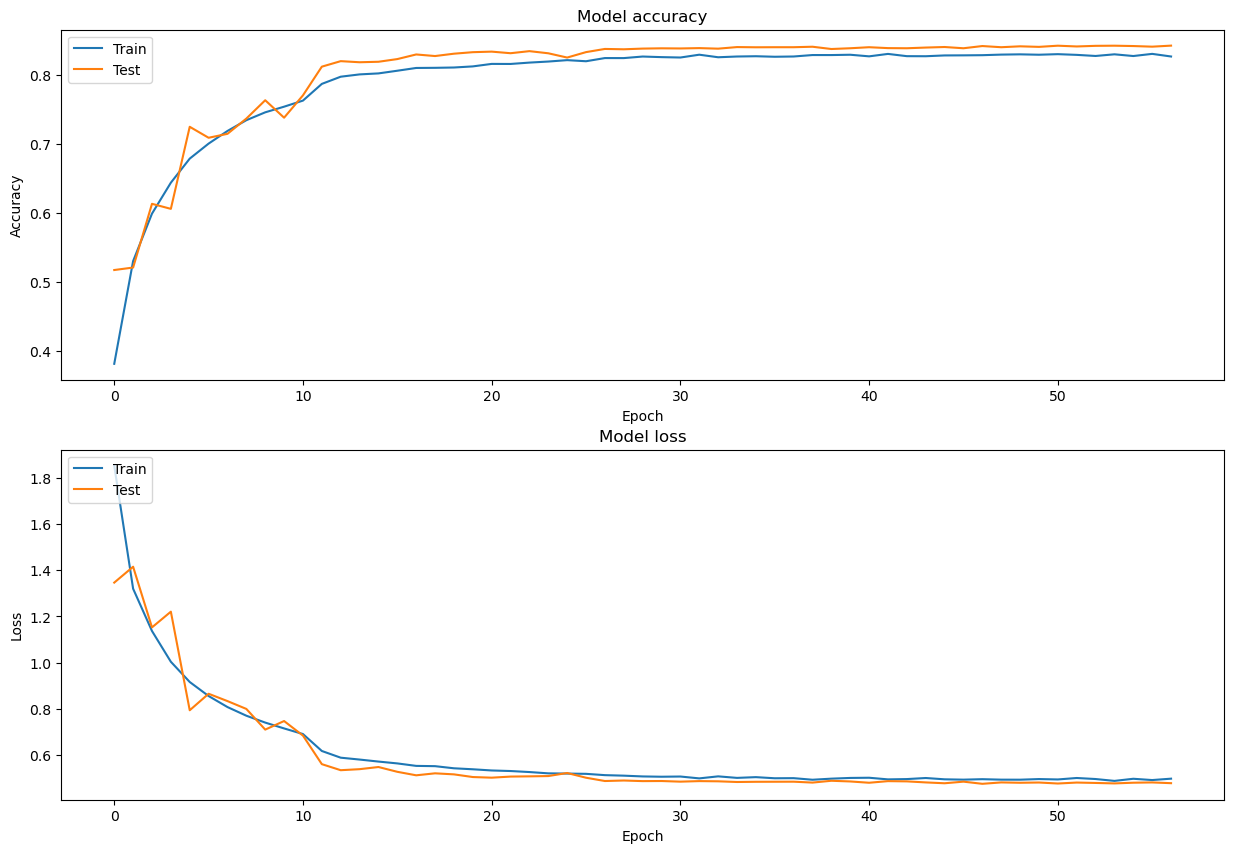

In [8]:
# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')

plt.show()